In [1]:
import sys
sys.path.append('..')
from src.evo_eq_model import *

In [2]:

home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)
import analysis.mathematical_functions.funcs as funcs

In [3]:
import random
import numpy.random as rnd
import networkx as nx
from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import sys
# from jupyter_server import serverapp as app; 
# import ipykernel, requests;
if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle

import pandas as pd
import scipy.interpolate as spi
import scipy.optimize as so

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

from matplotlib.ticker import FuncFormatter

fmt = lambda x, pos: '{:.1f}'.format(x)
from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rc('mathtext', default='regular')
plt.rc('lines', linewidth=2.0)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.rcParams['axes.labelsize']=20
plt.rcParams['legend.fontsize']= 20
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['figure.titlesize'] = 20
#set legend titlesize to 40
plt.rcParams['legend.title_fontsize'] = 20

In [4]:
def model(X, t, R0, kappa):
    x = X[0]
    y = X[1]
    z = X[2]
    dxdt = - R0/(1+kappa * y) *x * y
    dydt =  R0/(1+kappa* y) * x * y - y
    dzdt = y
    return [dxdt, dydt, dzdt]

def model_w_params(R0, N, k): 
    def model(y,t):
        S = y[0]
        I = y[1]
        R0_eff = R0/(1+k*I/(N))
        dSdt = - R0_eff * S*I/N 
        dIdt =  R0_eff * S*I/N -I
        return [dSdt,dIdt]
    return model

@jit(nopython=True)    
def find_t_intersection(f,g, t):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return t[idx[0]]
    else:
        return np.inf

@jit(nopython=True)    
def find_ind_intersection(f,g):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return idx[0]
    else:
        return np.inf

@jit(nopython=True)
def get_p_surv_inv_int(fit, dt,reg= 1e-1):
    L = len(fit)
    pi_ext_ode_hand_inv_t = np.zeros(L)
    pi_ext_ode_hand_inv_t[-1] = np.minimum(1/(1+fit[-1]),1-reg)
    for i in range(L-1):
        pi_ext= pi_ext_ode_hand_inv_t[L-1-i]
        pi_ext_ode_hand_inv_t[L-2-i] = pi_ext -dt * (1-pi_ext)*(-1+pi_ext*(1+fit[L-2-i]))
    p_surv = 1-pi_ext_ode_hand_inv_t
    return p_surv

def find_x_inf(R0,k):
    if k>0:
        c = (R0-k+R0*k)/(k*(R0-k))
        rho = 1/(R0/k)
        y_x = lambda x: c*x**rho + x/(rho-1) - 1/k

        roots = so.fsolve(y_x, 0)
        return roots[0]
    else:
        return np.real(-1/R0*sps.lambertw(-R0*np.exp(-R0)))
    
def integrate_trajectory(R0,kappa,N, I0=10):
    S0 = N-I0
    y0 = [S0,I0]
    x_inf = find_x_inf(R0,kappa)
    
    t_end = 1.5*np.log(N)* (1/(R0-1) + 1/(1-R0*x_inf))
    ts = np.linspace(0, t_end,100000)
    dt = ts[1]-ts[0]
    solution  = odeint(model_w_params(R0,N,kappa),y0,ts).T
    x,y= solution
    tp = ts[np.argmax(y)]


    return ts, solution

In [5]:
home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)
output_folder= project_path+'/outputs/'

In [6]:
c_d = lambda d,xi: np.exp(-d/xi)
rho_d = lambda d,dbar: 1/dbar*(1-1/dbar)**(d-1)

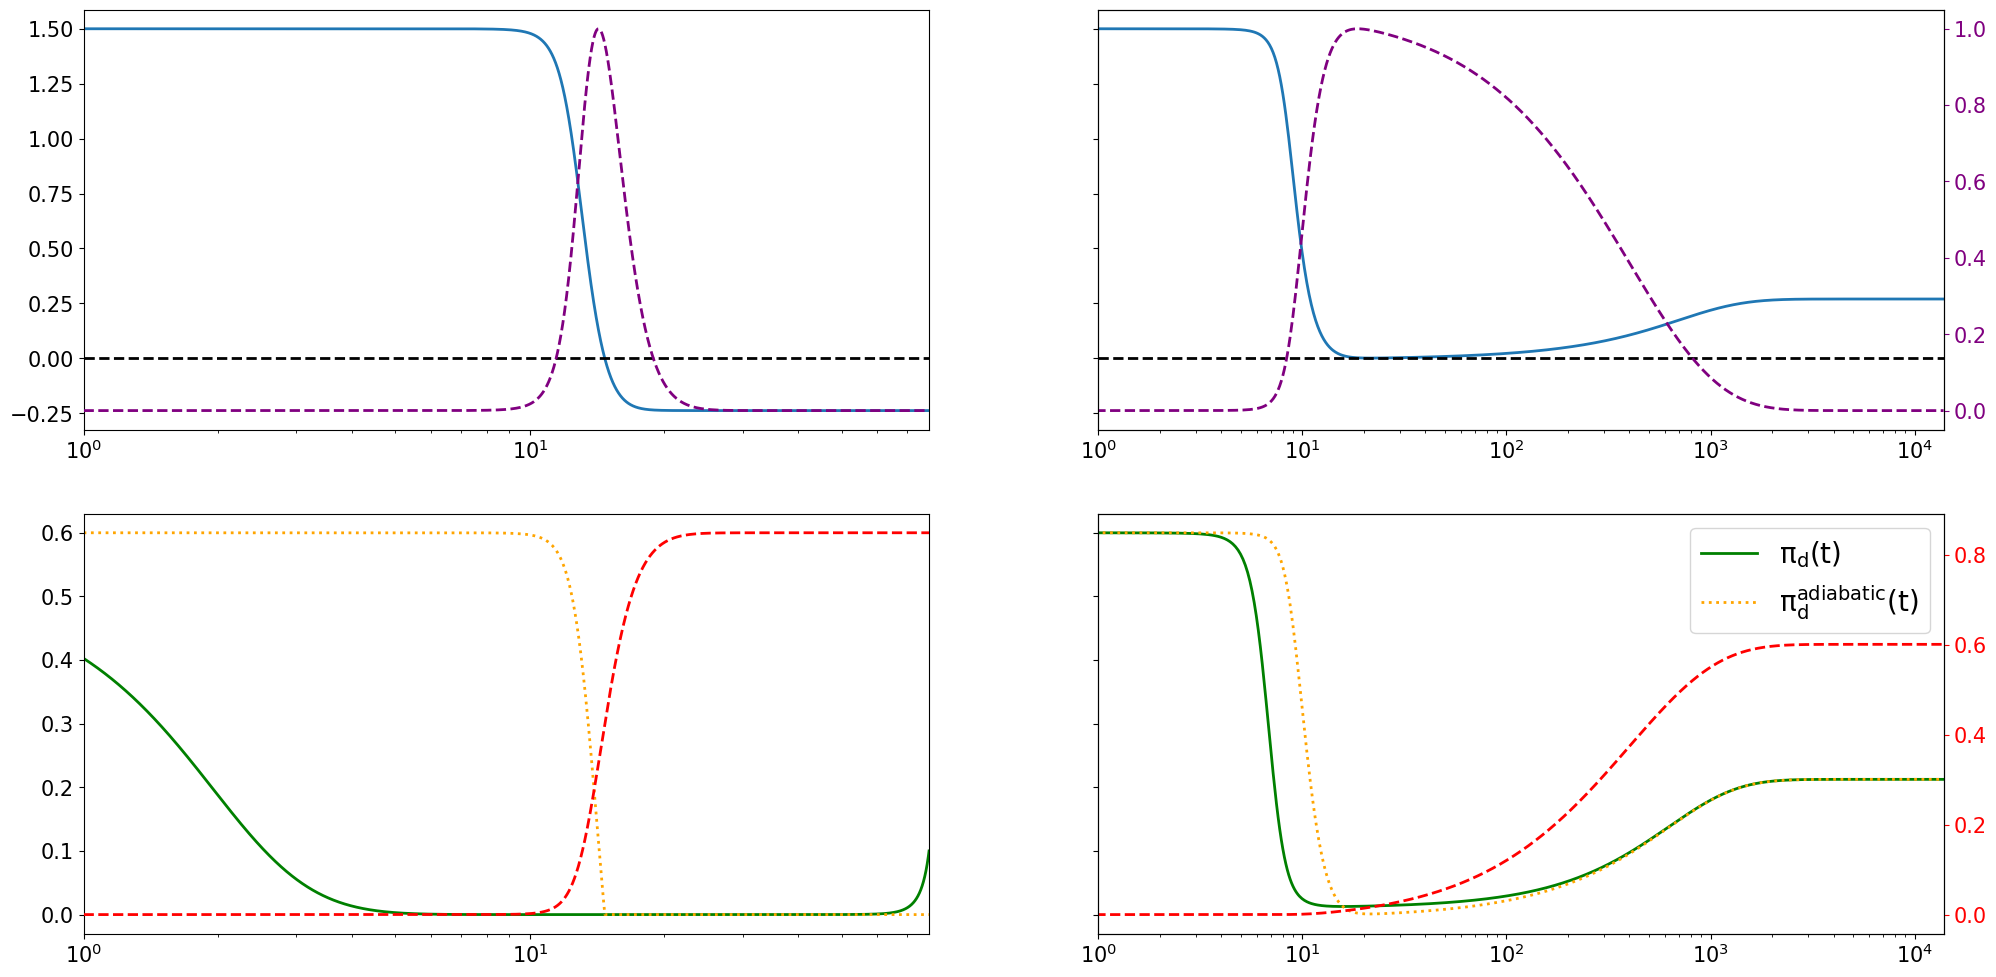

In [7]:
R0 = 2.5
N=1e10
dbar = 10
d = dbar
xi = 50
c = np.exp(-d/xi)


fit_func = lambda x,y,z, c, R0, kappa: R0/(1+kappa*y) * (x + (1-c)*z) -1 

small_kappa = 1
ts_small, sol_small = integrate_trajectory(R0,small_kappa,N)
S_small, I_small = sol_small
x_small, y_small = S_small/N, I_small/N
z_small = 1-x_small-y_small
fit_small = fit_func(x_small,y_small,z_small,c, R0, small_kappa)
p_surv_small = get_p_surv_inv_int(fit_small, ts_small[1]-ts_small[0])
p_surv_adiab_small = np.maximum(fit_small/(1+fit_small),0)

big_kappa = 1e3
ts_big, sol_big = integrate_trajectory(R0,big_kappa,N)
S_big, I_big = sol_big
x_big, y_big = S_big/N, I_big/N
z_big = 1-x_big-y_big
fit_big = fit_func(x_big,y_big,z_big,c, R0, big_kappa)

p_surv_big = get_p_surv_inv_int(fit_big, ts_big[1]-ts_big[0])
p_surv_adiab_big = np.maximum(fit_big/(1+fit_big),0)

fig, ax = plt.subplots(2,2,figsize=(24,12),sharey='row')

ax[0,0].plot(ts_small, fit_small)
ax[0,0].axhline(0,color='black',ls='--')
tax00 = ax[0,0].twinx()
tax00.plot(ts_small, y_small/np.max(y_small), color='purple', ls= '--')
ax[1,0].plot(ts_small, p_surv_small,color='green')
ax[1,0].plot(ts_small, p_surv_adiab_small,color='orange',ls=':')
tax10 = ax[1,0].twinx()
tax10.plot(ts_small, z_small, color='red', ls= '--')
axs_small = ax[:,0]
for a in axs_small:
    a.set_xlim(left=1, right =ts_small[-1])


tax01 = ax[0,1].twinx()
ax[0,1].plot(ts_big, fit_big)
ax[0,1].axhline(0,color='black',ls='--')
tax01.plot(ts_big, y_big/np.max(y_big), color='purple', ls= '--')
ax[1,1].plot(ts_big, p_surv_big,color='green',label = r'$\pi_d(t)$')
ax[1,1].plot(ts_big, p_surv_adiab_big,color='orange',ls=':',label = r'$\pi_d^{\mathrm{adiabatic}}(t)$')
tax11 = ax[1,1].twinx()
tax11.plot(ts_big, z_big, color='red', ls= '--')


axs_big = ax[:,1]

for a in axs_big:
    a.set_xlim(left=1, right =ts_big[-1])

for a in ax.flatten():
    a.set_xscale('log')
    # a.set_yscale('log')
    
    # a.set_ylim([1e-4,1])


tax11.set_ylim(tax10.get_ylim())
tax10.axis('off')

tax00.set_ylim([-0.05,1.05])
tax01.set_ylim([-0.05,1.05])
tax00.axis('off')

tax01.tick_params(axis='y', colors='purple')
tax11.tick_params(axis='y', colors='red')

ax[1,1].legend(loc='best',fontsize=20)
# plt.savefig(output_folder+'fit_and_est.svg',bbox_inches='tight')


In [8]:
# ds = np.arange(1,10*dbar)
# rhos = rho_d(ds,dbar).reshape(-1,1)
# fit_d_t_small = np.array( [fit_func(x_small,y_small,z_small,c_d(d,xi), R0, kappa_small) for d in ds])
# p_surv_d_t_small = np.array([get_p_surv_inv_int(fit_d, ts_small[1]-ts_small[0]) for fit_d in fit_d_t_small])
# p_surv_d_t_adiab_small = np.maximum(fit_d_t_small/(1+fit_d_t_small),0)

# emergence_d_t_small = U*N* y_small*p_surv_d_t_small *rhos
# emergence_d_t_adiab_small = U*N* y_small*p_surv_d_t_adiab_small *rhos
# emergence_t_small = np.sum(emergence_d_t_small,axis=0)



In [9]:
# df_small_grouped

In [10]:
# sns.lineplot(data=df_small, x='t',y='emergence',hue='d')

In [11]:
# sns.lineplot(data=df_small_grouped, x='t',y='emergence',hue='d_bin',legend='brief')#,plotevery=10)
# sns.lineplot(data=df_small_grouped, x='t',y='emergence_adiab',hue='d_bin',legend='brief')#,plotevery=10)

In [12]:
from matplotlib.ticker import ScalarFormatter

y_formatter = ScalarFormatter(useOffset=False)


In [13]:
def exp_notation_string(x):
    ex = np.floor(np.log10(x))
    base = x/10**ex
    if ex!=0:
        return fr'${base:.1f}\times 10^{{{int(ex)}}}$'
    else:
        return fr'${base:.1f}$'

print(exp_notation_string(5.6e-3))

$5.6\times 10^{-3}$


/var/folders/r0/2r01pw2j68bcxs_rw3gqyh880000gn/T/ipykernel_26105/3129638371.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  emergence_df_small_grouped = emergence_df_small.groupby(['t','d_bin','kappa']).sum().reset_index()
/var/folders/r0/2r01pw2j68bcxs_rw3gqyh880000gn/T/ipykernel_26105/3129638371.py:80: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  emergence_df_big_grouped = emergence_df_big.groupby(['t','d_bin','kappa']).sum().reset_index()


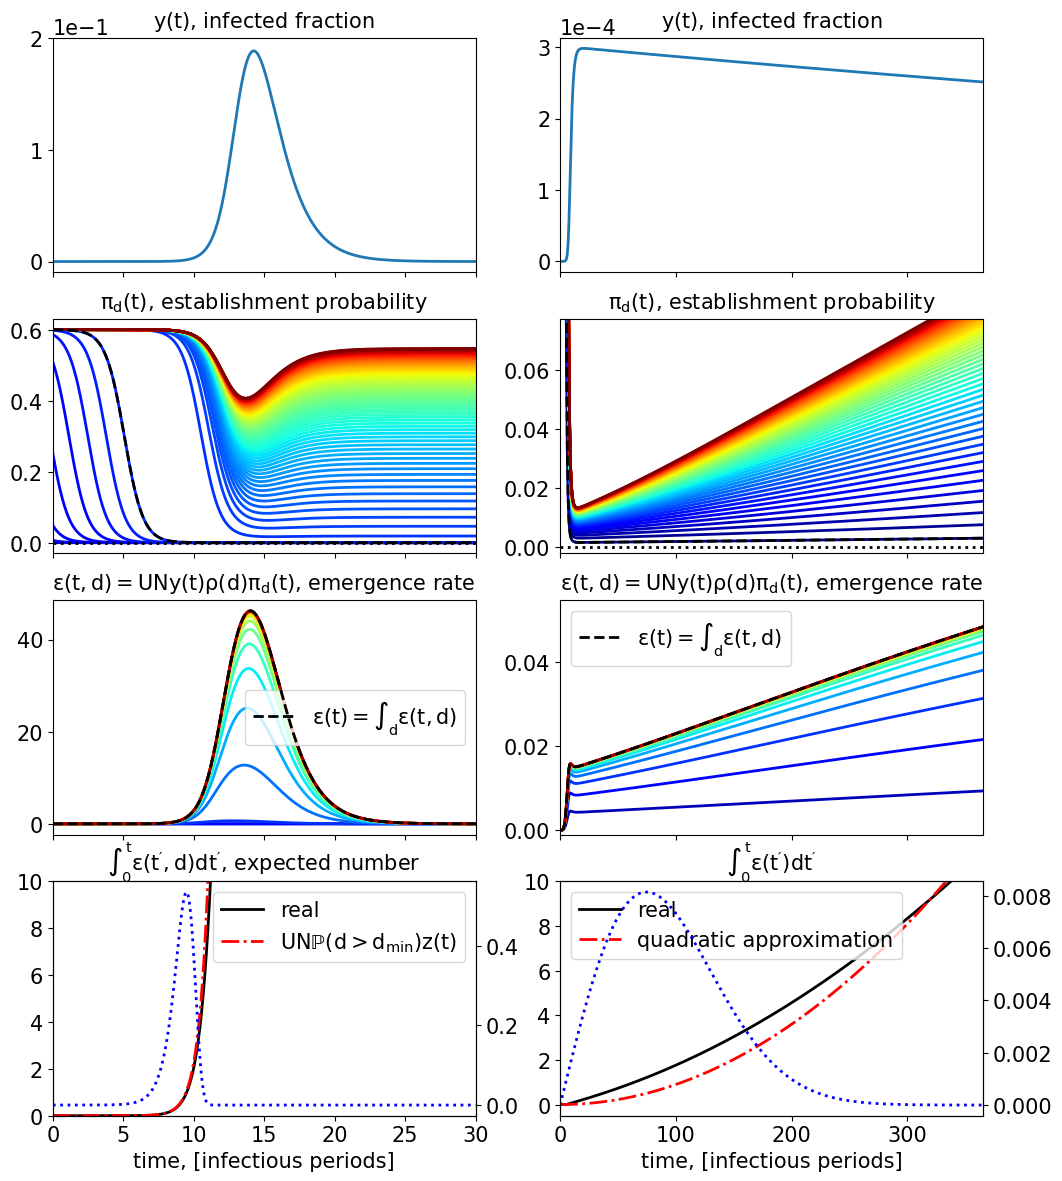

In [14]:
R0 = 2.5
N=1e10
dbar = 10
xi = 50
delta= dbar/xi
deltacorr = delta/(1+delta)
U = 1e-6
ds = np.arange(1,10*dbar)
rhos = rho_d(ds,dbar).reshape(-1,1)
plot_adiabatic = False

colors_d= funcs.color_dict(ds,plt.cm.jet)

fit_func = lambda x,y,z, c, R0, kappa: R0/(1+kappa*y) * (x + (1-c)*z) -1 
savefig = 1

dbinsize= 6

compute_kappa_small = 1
if compute_kappa_small:
    kappa_small = 1
    ts_small, sol_small = integrate_trajectory(R0,kappa_small,N)
    S_small, I_small = sol_small
    xs_small, ys_small = S_small/N, I_small/N
    zs_small = 1-xs_small-ys_small
    zinf_small = 1-funcs.x_inf(R0,kappa_small)
    dmin_small = xi*np.log(R0/(R0-1)*zinf_small)
    tp_small = ts_small[np.argmax(ys_small)]

    fit_d_t_small = np.array( [fit_func(xs_small,ys_small,zs_small,c_d(d,xi), R0, kappa_small) for d in ds])
    p_surv_d_t_small = np.array([get_p_surv_inv_int(fit_d, ts_small[1]-ts_small[0],reg=1e-5) for fit_d in fit_d_t_small])
    p_surv_d_t_adiab_small = np.maximum(fit_d_t_small/(1+fit_d_t_small),0)

    emergence_d_t_small = U*N* ys_small*p_surv_d_t_small *rhos# *(ds>dmin_small).reshape(-1,1)
    emergence_d_t_adiab_small = U*N* ys_small*p_surv_d_t_adiab_small*rhos*(ds>dmin_small).reshape(-1,1)
    emergence_t_small = np.sum(emergence_d_t_small,axis=0)
    cumemergence_t_small = np.cumsum(emergence_t_small,axis=0)*ts_small[1]
    cumemergence_d_t_small = np.cumsum(emergence_d_t_small,axis=0)

    tt_small,dd = np.meshgrid(ts_small,ds)
    emergence_df_small = pd.DataFrame({'t':tt_small.flatten(),'d':dd.flatten(),'emergence':emergence_d_t_small.flatten(),'emergence_adiab':emergence_d_t_adiab_small.flatten(), 'cumulative_emergence':cumemergence_d_t_small.flatten()})
    emergence_df_small['kappa'] = small_kappa
    #group by d in with bin size 10 and sum

    ######### emergence_dataframe
    emergence_df_small['d_bin'] = pd.cut(emergence_df_small['d'], bins=np.arange(0,ds.max()+1,dbinsize))
    emergence_df_small_grouped = emergence_df_small.groupby(['t','d_bin','kappa']).sum().reset_index()
    emergence_df_small['d_mid'] = emergence_df_small['d_bin'].apply(lambda x: x.mid) 
    emergence_df_small_grouped['d_mid']= emergence_df_small_grouped['d_bin'].apply(lambda x: x.mid)

compute_kappa_big = 1
if compute_kappa_big:
    kappa_big= 5e3
    ts_big, sol_big = integrate_trajectory(R0,kappa_big,N)
    S_big, I_big = sol_big
    xs_big, ys_big = S_big/N, I_big/N
    zs_big = 1-xs_big-ys_big
    zinf_big = 1-funcs.x_inf(R0,kappa_big)
    dmin_big = xi*np.log(R0/(R0-1)*zinf_big)

    fit_d_t_big = np.array( [fit_func(xs_big,ys_big,zs_big,c_d(d,xi), R0, kappa_big) for d in ds])
    p_surv_d_t_big = np.array([get_p_surv_inv_int(fit_d, ts_big[1]-ts_big[0],reg=1e-5) for fit_d in fit_d_t_big])
    p_surv_d_t_adiab_big = np.maximum(fit_d_t_big/(1+fit_d_t_big),0)

    emergence_d_t_big = U*N* ys_big*p_surv_d_t_big *rhos * (ds>dmin_big).reshape(-1,1)
    emergence_d_t_adiab_big = U*N* ys_big*p_surv_d_t_adiab_big *rhos * (ds>dmin_big).reshape(-1,1)
    emergence_t_big = np.sum(emergence_d_t_big,axis=0)
    emergence_t_adiab_big = np.sum(emergence_d_t_adiab_big,axis=0)
    cumemergence_t_big = np.cumsum(emergence_t_big,axis=0)*ts_big[1]
    cumemergence_d_t_big = np.cumsum(emergence_d_t_big,axis=0)
    cumemergence_t_analytical_big = U*N* delta*((R0-1)/kappa_big)**2 *ts_big**2/2

    tt_big,dd = np.meshgrid(ts_big,ds)
    emergence_df_big = pd.DataFrame({'t':tt_big.flatten(),'d':dd.flatten(),'emergence':emergence_d_t_big.flatten(),'emergence_adiab':emergence_d_t_adiab_big.flatten(),'cumulative_emergence': cumemergence_d_t_big.flatten()})
    emergence_df_big['kappa'] = big_kappa
    #group by d in with bin size 10 and sum

    ######### emergence_dataframe
    emergence_df_big['d_bin'] = pd.cut(emergence_df_big['d'], bins=np.arange(0,ds.max()+1,dbinsize))
    emergence_df_big_grouped = emergence_df_big.groupby(['t','d_bin','kappa']).sum().reset_index()
    emergence_df_big['d_mid'] = emergence_df_big['d_bin'].apply(lambda x: x.mid)
    emergence_df_big_grouped['d_mid']= emergence_df_big_grouped['d_bin'].apply(lambda x: x.mid)

fig,ax= plt.subplots(4,2,figsize=(12,14),sharex='col')
ax = ax.flatten()

plot_kappa_small = True
if plot_kappa_small:
    ax_y_small = ax[0]
    ax_pi_small = ax[2]
    ax_emergence_small = ax[4]
    ax_cumemergence_small = ax[6]

    # tax2 = ax[2].twinx()

    ax_y_small.plot(ts_small,ys_small)
    for d in ds[::1]:
        
        # ax_pi_small.plot(ts_small, fit_d_t_small[d-1], alpha=0.5,color = colors_d[d])
        # ax_pi_small.plot(ts_small, np.average(p_surv_d_t_small[d-1:d+dbinsize-1],axis=0),label = f'd={d}',color=colors_d[d],lw=2)
        ax_pi_small.plot(ts_small, p_surv_d_t_small[d-1],label = f'd={d}',color=colors_d[d],lw=2)
        
        # ax_emergence_small.plot(ts_small, emergence_d_t_small[d],label = f'd={d}',color=colors_d[d],lw=1)
        if d>dmin_small and plot_adiabatic:
            ax_pi_small.plot(ts_small, np.average(p_surv_d_t_adiab_small[d-1:d+dbinsize-1],axis=0),label = f'd={d}',color=colors_d[d],ls= ':',lw=1)
            # ax_emergence_small.plot(ts_small, emergence_d_t_adiab_small[d],label = f'd={d}',color=colors_d[d],lw=1,ls=':')
    ax_pi_small.plot(ts_small, p_surv_d_t_small[np.round(dmin_small).astype(int)-1],color='black',ls='--')#,label = r'$\pi_d(t)$, $d=\xi \log\left(\frac{R_0}{R_0-1}z_{\infty}\right)$'
    sns.lineplot(data=emergence_df_small.query('d%6==0'), x='t',y='cumulative_emergence',hue='d',legend=False,ax=ax_emergence_small,palette=colors_d)
    # sns.lineplot(data=emergence_df_small_grouped, x='t',y='emergence_adiab',hue='d_mid',legend=False,ax=ax_emergence_small,palette=colors_d,ls=':')
    ax_emergence_small.plot(ts_small,emergence_t_small,color='black',ls='--',label=r'$\varepsilon(t)=\int_d \varepsilon(t,d)$',zorder =10)
    ax_cumemergence_small.plot(ts_small,cumemergence_t_small,color='black',ls='-',label='real')
    # ax_cumemergence_small.plot(ts_small, U*N*delta/(1+delta)*zs_small,color='red',ls=':', label=r'$U N \delta z(t) $')
    al = (-1 + R0)/(R0*((R0*zinf_small)/(-1 + R0))**(1/delta))
    #al but in tex
    # al = \frac{R_0-1}{R_0}\left(\frac{R_0z_{\infty}}{R_0-1}\right)^{-\frac{1}{\delta}}
    ax_cumemergence_small.plot(ts_small, U*N*al*zs_small,color='red',ls='-.', label=r'$U N \mathbb{P}(d>d_\mathrm{min}) z(t)$')

    tax_cumemergence_small = ax_cumemergence_small.twinx()
    pdf_first_small = emergence_t_small*np.exp(-cumemergence_t_small)
    tax_cumemergence_small.plot(ts_small,pdf_first_small,color='blue',ls=':',label='pdf first emergence')
    
    ax_y_small.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
    ax_y_small.set_yticks(np.arange(3)*1e-1)
    ax_y_small.set_title(r'$y(t)$, infected fraction',fontsize=15,y= 1.01)
    ax_pi_small.set_title(r'$\pi_d(t)$, establishment probability',fontsize=15,y= 1.01)
    ax_pi_small.set_xlim(0,30)
    ax_pi_small.axhline(0,color='black',ls=":")
    ax_emergence_small.legend(loc='best',fontsize=15)
    ax_emergence_small.set_title(r'$\varepsilon(t,d)= UN y(t)\rho(d)\pi_d(t) $, emergence rate',fontsize=15,y= 1.01)

    ax_cumemergence_small.set_title(r'$\int_0^t \varepsilon(t^\prime,d) dt^\prime$, expected number',fontsize=15,y= 1.01)
    ax_cumemergence_small.legend(loc='best',fontsize=15)
    ax_cumemergence_small.set_xlabel('time, [infectious periods]',fontsize=15)
    ax_cumemergence_small.set_ylim(0,10)

plot_kappa_big = True
if plot_kappa_big:      
    ax_y_big = ax[1]
    ax_pi_big = ax[3]
    ax_emergence_big = ax[5]
    ax_cumemergence_big = ax[7]

    ax_y_big.plot(ts_big,ys_big)
    ax_y_big.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

    for d in ds[::2]:
        # ax_pi_big.plot(ts_big, fit_d_t_big[d-1], alpha=0.5,color = colors_d[d])
        # ax_pi_big.plot(ts_big, np.average(p_surv_d_t_big[d-1:d+dbinsize-1],axis=0),label = f'd={d}',color=colors_d[d],lw=2)
        ax_pi_big.plot(ts_big, p_surv_d_t_big[d-1],label = f'd={d}',color=colors_d[d],lw=2)
        # ax_emergence_big.plot(ts_big, emergence_d_t_big[d],label = f'd={d}',color=colors_d[d],lw=1)
        if d>dmin_big and plot_adiabatic:
            ax_pi_big.plot(ts_big,  np.average(p_surv_d_t_adiab_big[d-1:d+dbinsize-1],axis=0),label = f'd={d}',color=colors_d[d],ls= ':',lw=1)
            # ax_emergence_big.plot(ts_big, emergence_d_t_adiab_big[d],label = f'd={d}',color=colors_d[d],lw=1,ls=':')
    ax_pi_big.plot(ts_big, p_surv_d_t_big[np.round(dmin_big).astype(int)],color='black',ls='--')#,label = r'$\pi_d(t)$, $d=\xi \log\left(\frac{R_0}{R_0-1}z_{\infty}\right)$'
    sns.lineplot(data=emergence_df_big.query('d%6==0'), x='t',y='cumulative_emergence',hue='d',legend=False,ax=ax_emergence_big,palette=colors_d)
    # sns.lineplot(data=emergence_df_big_grouped, x='t',y='emergence_adiab',hue='d_mid',legend=False,ax=ax_emergence_big,palette=colors_d,ls=':')
    ax_emergence_big.plot(ts_big,emergence_t_big,color='black',ls='--',label=r'$\varepsilon(t)=\int_d \varepsilon(t,d)$',zorder=10)
    ax_cumemergence_big.plot(ts_big,cumemergence_t_big,color='black',ls='-',label='real')
    ax_cumemergence_big.plot(ts_big,cumemergence_t_analytical_big,color='red',ls='-.',label='quadratic approximation')
    

    tax_cumemergence_big = ax_cumemergence_big.twinx()
    emergence_t_analytical_big = U*N*delta*((R0-1)/kappa_big)**2 *ts_big
    pdf_first_big = emergence_t_analytical_big*np.exp(-cumemergence_t_analytical_big)
    tax_cumemergence_big.plot(ts_big,pdf_first_big,color='blue',ls=':',label='pdf first emergence')

    ax_pi_big.set_xlim(-1/kappa_big,kappa_big/(R0-1)* np.sqrt(20/(U*N*deltacorr)))
    ax_pi_big.set_ylim(-10/kappa_big,np.sqrt(10/(U*N*deltacorr)))
    ax_pi_big.axhline(0,color='black',ls=":")
    ax_y_big.set_title(r'$y(t)$, infected fraction',fontsize=15,y= 1.01)
    ax_pi_big.set_title(r'$\pi_d(t)$, establishment probability',fontsize=15,y= 1.01)

    emergence_big_ylim_top = np.sqrt(20* U*N*deltacorr)*(R0-1)/kappa_big

    ax_emergence_big.set_ylim(-1e-3,emergence_big_ylim_top)
    ax_emergence_big.legend(loc='best',fontsize=15)
    ax_emergence_big.set_title(r'$\varepsilon(t,d)= UN y(t)\rho(d)\pi_d(t) $, emergence rate',fontsize=15,y= 1.01)

    ax_cumemergence_big.set_ylim(-.5,10)
    ax_cumemergence_big.set_title(r'$\int_0^t \varepsilon(t^\prime) dt^\prime$',fontsize=15,y= 1.01)
    ax_cumemergence_big.set_xlabel('time, [infectious periods]',fontsize=15)
    ax_cumemergence_big.legend(loc='best',fontsize=15)
    ax_cumemergence_big.set_yticks(ax_cumemergence_small.get_yticks())

for a in ax:
    a.set_ylabel('')

# handles_d = [Line2D([0], [0], color=colors_d[d], lw=2, label = r'$\frac{d}{\xi}=$'+ exp_notation_string(d/xi) ) for d in ds[::dbinsize]]
# ax[5].legend(handles=handles_d,loc=(1.01,.1),fontsize=15)
savefig=1
if savefig:
    plt.savefig(output_folder+f'comparison_kappa_small_{small_kappa:.0e}_big_{big_kappa:.0e}_d_{dbar}_xi_{xi}_R0_{R0}_UN_{U*N:.0e}.svg',bbox_inches='tight')

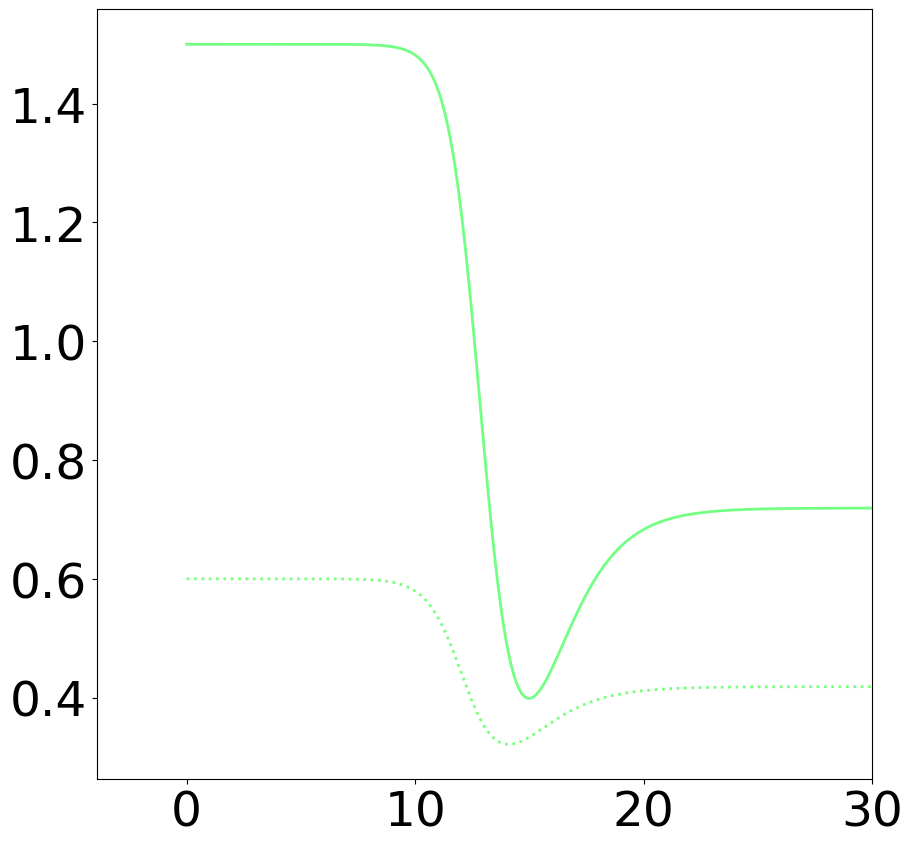

In [23]:
fig,ax= plt.subplots(figsize=(10,10))

d = 50
ax.plot(ts_small, fit_d_t_small[d-1] , color = colors_d[d-1])

ax.plot(ts_small, p_surv_d_t_small[d-1],label = f'd={d}',color=colors_d[d],lw=2, ls=':')
# ax.plot(ts_small, p_surv_d_t_adiab_small[d-1], color= colors_d[d],ls= ':')
ax.set_xlim(right=30)
ax.tick_params(axis='both',labelsize=35)
plt.savefig(output_folder+'lone_fitness.svg')

In [ ]:
                           
    # junk = False
    # if junk:
    #     print('junk')
    #     # zinf_small = 1-funcs.x_inf(R0,small_kappa)
    #     # zp_small = zs_small[np.argmax(ys_small)]
        
    #     # ax_cumemergence_small.axhline(U*N*deltacorr*((zinf_small)**2/2 - zp_small**2/2),color='red',ls='--')

    #     # exp_branch_right = 1/2 + 1/2*(1- np.exp(final_g_rate*(ts_small[ts_small>=tp_small]-tp_small)) )
    #     # exp_branch_left = np.exp((R0-1)*ts_small[ts_small<tp_small])/N
    #     # final_g_rate = R0*find_x_inf(R0,small_kappa)-1
    #     # ax_cumemergence_small.plot(ts_small[ts_small<tp_small],np.exp((R0-1)*ts_small[ts_small<tp_small])/N,color='black',ls='--')
    #     # ax_cumemergence_small.plot(ts_small[ts_small>=tp_small],exp_branch_right,color='orange',ls='--')
    #     # ax_cumemergence_small.set_yscale('log')
    #     # tax0 = ax[0].twinx()
    #     # tax0.plot(ts_small,emergence_t_small,color='red',ls='--')
    #     # ax_pi_small.set_ylim(-.1,1)
    #     # ax_emergence_small.set_ylim(-.1,.5)

In [ ]:
cmax_big

0.9996667777407531

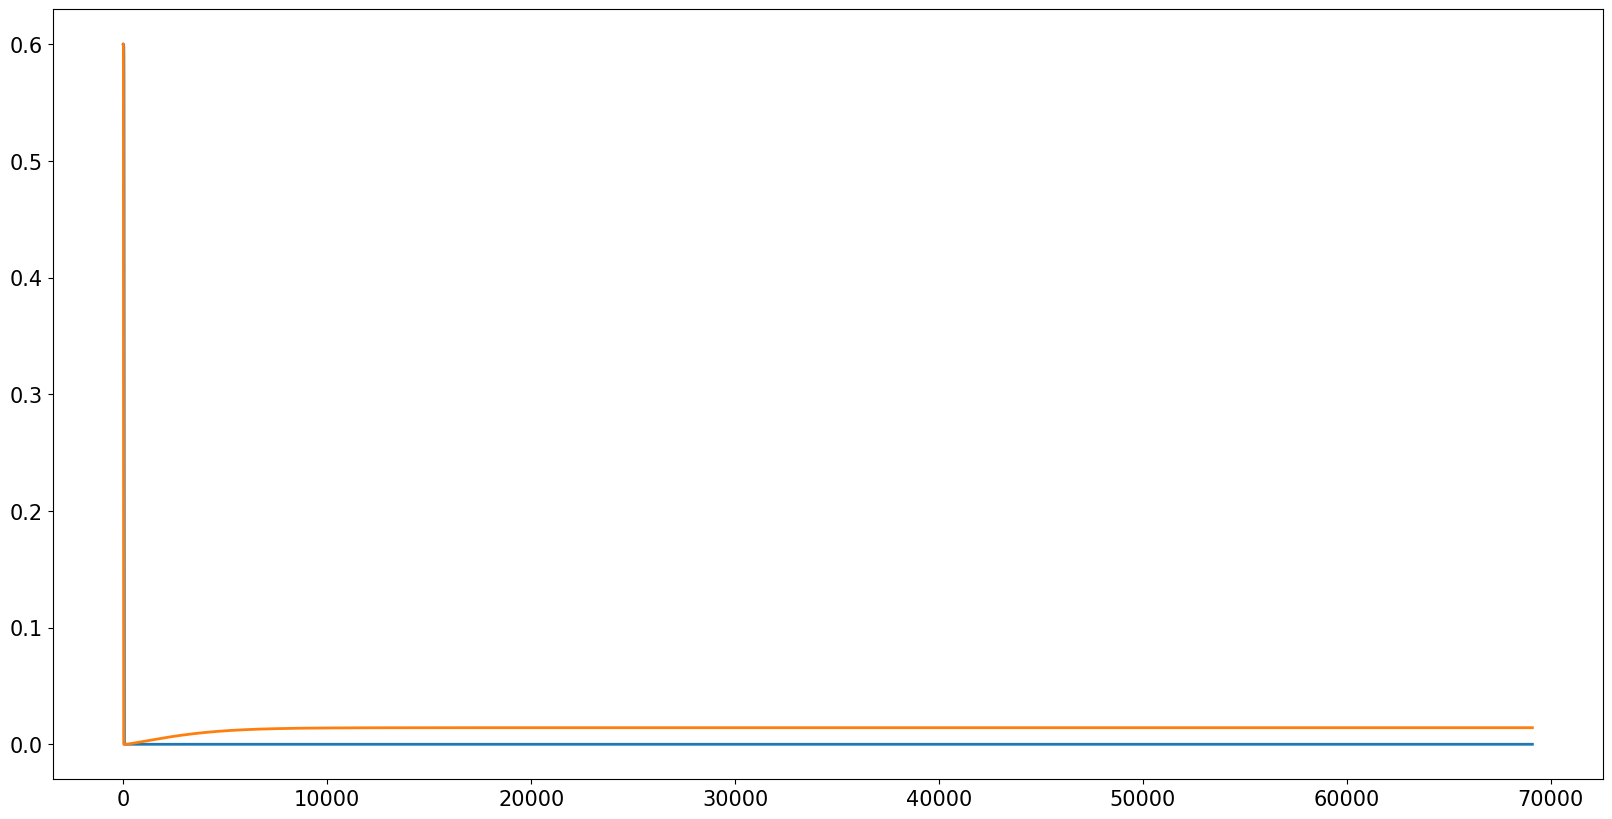

In [ ]:
cmax_big= (R0-1)/(R0*zinf_big)

fig,ax= plt.subplots()

f_min_big = R0/(1+kappa_big*y_big)*(x_big + (1-cmax_big)*z_big) -1

pi_min_big = np.maximum(f_min_big/(1+f_min_big),0)

ax.plot(ts_big,pi_min_big)
ax.plot(ts_big, p_surv_d_t_adiab_big[0])


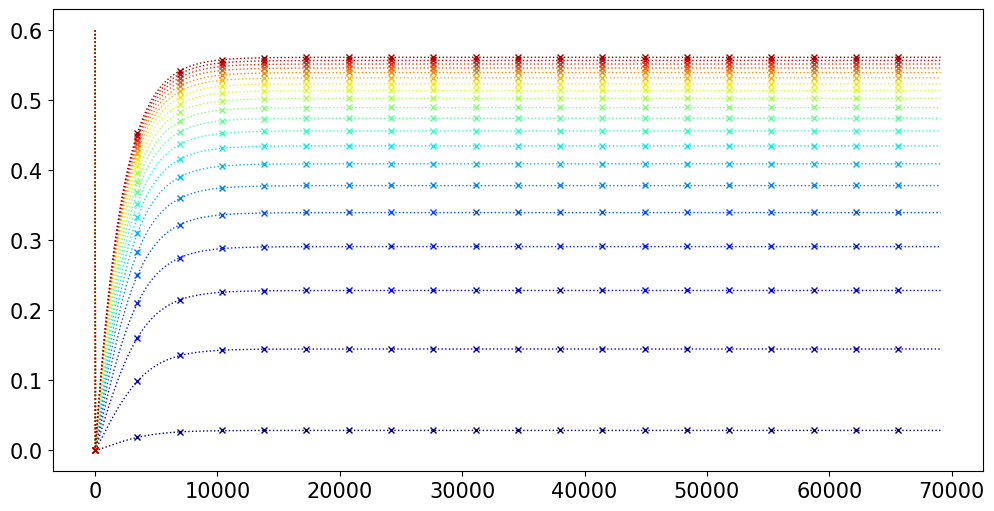

In [ ]:
fig,ax_pi_big = plt.subplots(1,1,figsize=(12,6))
plot_adiabatic = True
# ax_pi_big.plot(ts_big, p_surv_d_t_big[np.round(dmin_big).astype(int)],color='black',ls='--',label = r'$\pi_d(t)$, $d=\xi \log\left(\frac{R_0}{R_0-1}z_{\infty}\right)$')
for d in ds[::5]:
    # ax_pi_big.plot(ts_big, p_surv_d_t_big[d-1],label = f'd={d}',color=colors_d[d],lw=2)
    
    # ax_pi_big.plot(ts_big, (1-c_d(d,xi))*zs_big,label = f'd={d}',color=colors_d[d],ls= '-.',lw=1)
    # ax_pi_big.plot(ts_big, (1-c_d(d,xi))*zs_big/(1-zs_big),label = f'd={d}',color=colors_d[d],ls= '--',lw=1)
    ax_pi_big.plot(ts_big, (1-c_d(d,xi))*zs_big/(1-zs_big)/(1+(1-c_d(d,xi))*zs_big/(1-zs_big)),label = f'd={d}',color=colors_d[d],marker='x',lw=1,markevery=5000,ms=5,ls='')
    if d>dmin_big and plot_adiabatic:
        ax_pi_big.plot(ts_big, p_surv_d_t_adiab_big[d-1],label = f'd={d}',color=colors_d[d],ls= ':',lw=1)

# ax_pi_big.set_xlim(-1/kappa_big,kappa_big/(R0-1)* np.sqrt(10000/(U*N*deltacorr)))
# ax_pi_big.set_ylim(-10/kappa_big,np.sqrt(2/(U*N*deltacorr)))

Text(0.5, 1.01, '$\\varepsilon(t,d)= UN y(t)\\rho(d)\\pi_d(t) $, emergence rate')

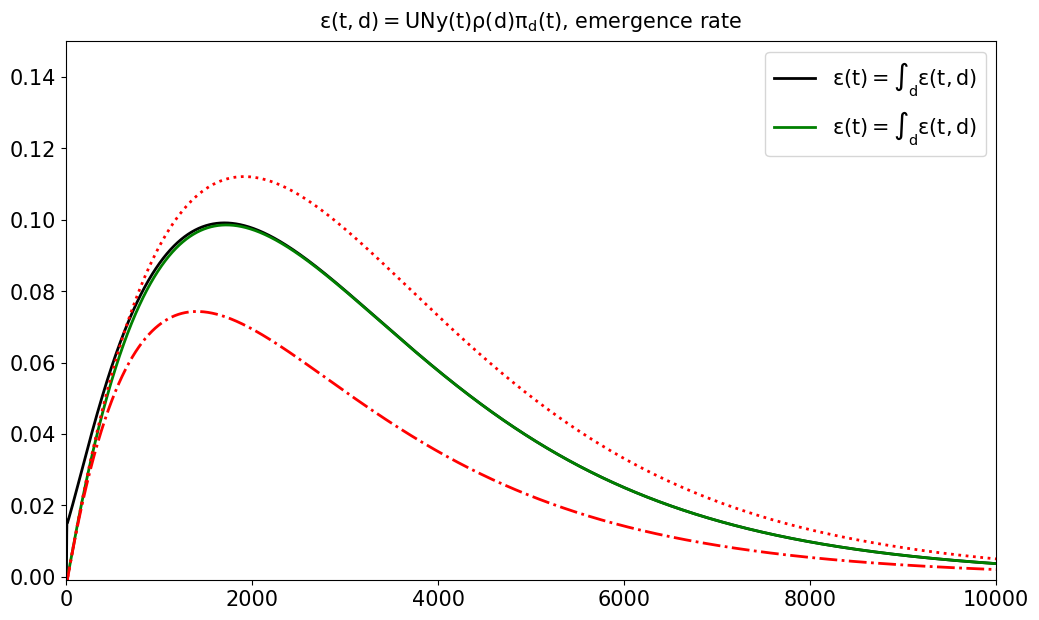

In [ ]:
fig, ax_emergence_big = plt.subplots(1,1,figsize=(12,7))
tp_big = ts_big[np.argmax(ys_big)]
ax_emergence_big.plot(ts_big,emergence_t_big,color='black',ls='-',label=r'$\varepsilon(t)=\int_d \varepsilon(t,d)$')
ax_emergence_big.plot(ts_big[ts_big>tp_big],emergence_t_adiab_big[ts_big>tp_big],color='green',ls='-',label=r'$\varepsilon(t)=\int_d \varepsilon(t,d)$')
# ax_emergence_big.plot(ts_big, U*N*delta*ys_big*zs_big/(1-zs_big),color='red',ls=':', label=r'$U N \delta z(t) $')
ax_emergence_big.plot(ts_big, U*N*ys_big*(delta/(1+delta)*zs_big/(1-zs_big)-R0/kappa_big),color='red',ls=':')#, label=r'$U N \delta z(t) $')
ax_emergence_big.plot(ts_big, U*N*ys_big*(delta/(1+delta)*zs_big-R0/kappa_big),color='red',ls='-.')#, label=r'$U N \delta z(t) $')
ax_emergence_big.set_ylim(-1e-3,.15)
ax_emergence_big.set_xlim(-1e-3,1e4)

ax_emergence_big.legend(loc='best',fontsize=15)
ax_emergence_big.set_title(r'$\varepsilon(t,d)= UN y(t)\rho(d)\pi_d(t) $, emergence rate',fontsize=15,y= 1.01)


In [ ]:
print(f'sum t_dep {np.sum(emergence_d_t_big*ts_big[1])}')
print(f'sum adiab {np.sum(emergence_d_t_adiab_big*ts_big[1])}')
print(f'UN*delta/(1+delta)*(-np.log(1-zinf_big)-zinf_big) {U*N*delta/(1+delta)*(-np.log(1-zinf_big)-zinf_big)}')
print(f'UN*delta * zinf_big**2/2 {U*N*delta*(zinf_big**2/2)}')


first_term_delta_big = -delta*(zinf_big + np.log(1-zinf_big))
second_term_delta_big = -3* delta**2 *((1-zinf_big/3)*(zinf_big/(1-zinf_big))+np.log(1-zinf_big))
print(U*N*(first_term_delta_big + second_term_delta_big))

print(1-np.exp(-np.sum(emergence_d_t_small*ts_small[1])))
print(1-np.exp(-np.sum(emergence_d_t_adiab_small*ts_small[1])))

sum t_dep 443.2589083080351
sum adiab 439.0168079278222
UN*delta/(1+delta)*(-np.log(1-zinf_big)-zinf_big) 527.6514281930622
UN*delta * zinf_big**2/2 360.2400399999999
292.2502418805544
1.0
1.0


In [ ]:
zinf_big

0.6002

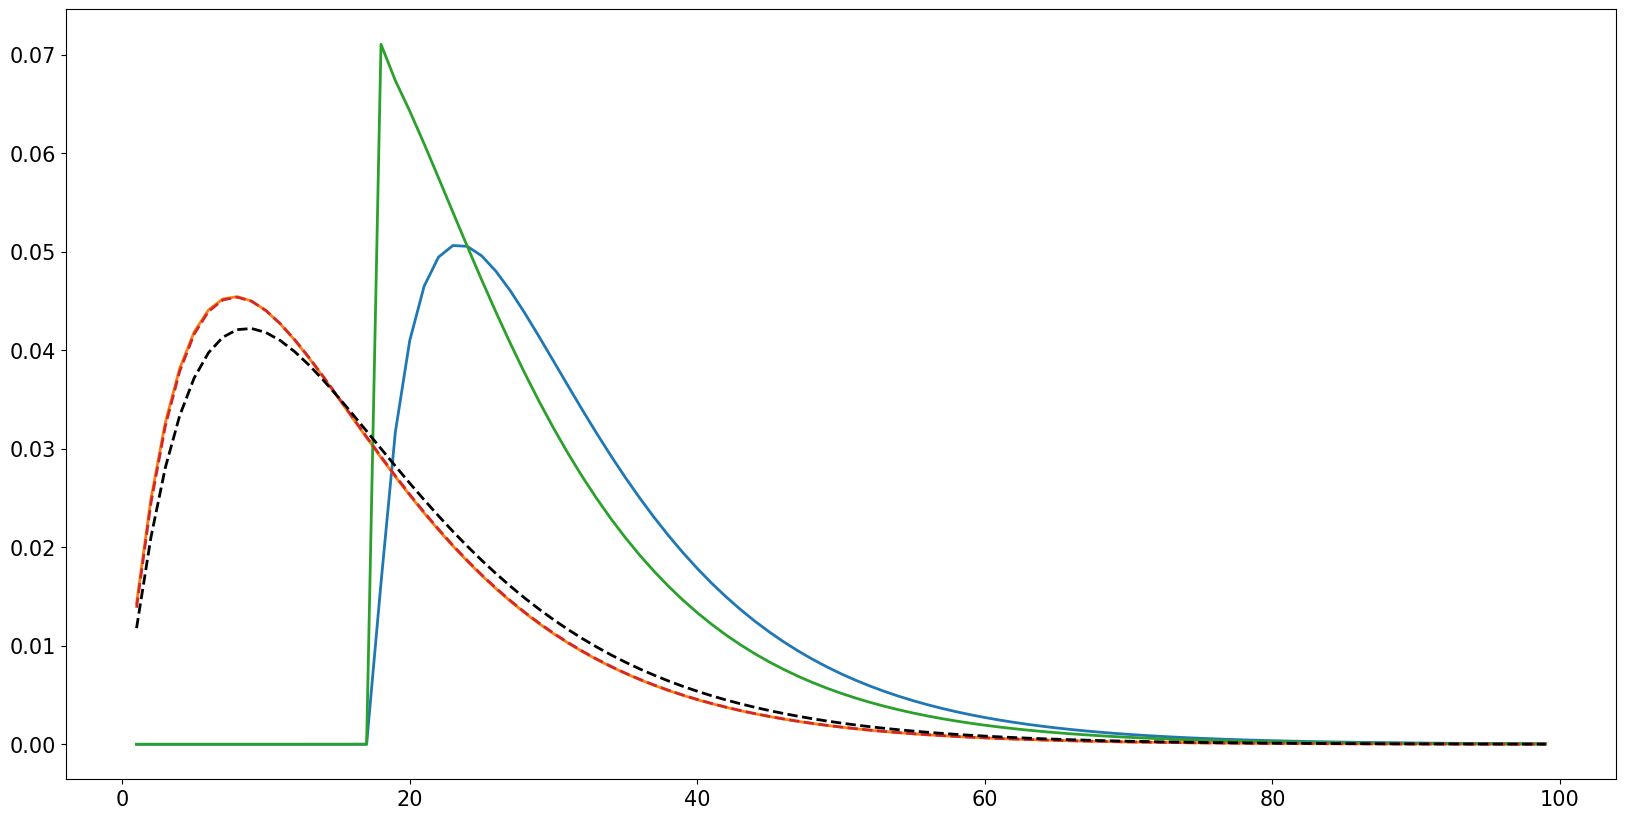

In [ ]:

plt.plot(ds,emergence_d_t_small.sum(axis=1)*ts_small[1]/np.sum(emergence_d_t_small.sum(axis=1)*ts_small[1]))
plt.plot(ds,emergence_d_t_big.sum(axis=1)*ts_big[1]/np.sum(emergence_d_t_big.sum(axis=1)*ts_big[1]))
plt.plot(ds,emergence_d_t_adiab_small.sum(axis=1)*ts_small[1]/np.sum(emergence_d_t_adiab_small.sum(axis=1)*ts_small[1]))
plt.plot(ds,emergence_d_t_adiab_big.sum(axis=1)*ts_big[1]/np.sum(emergence_d_t_adiab_big.sum(axis=1)*ts_big[1]),ls='--')
rhoc = rhos.flatten()*(1-np.exp(-ds/xi))
plt.plot(ds,rhoc/np.sum(rhoc),color='black',ls='--')
# plt.yscale('log')

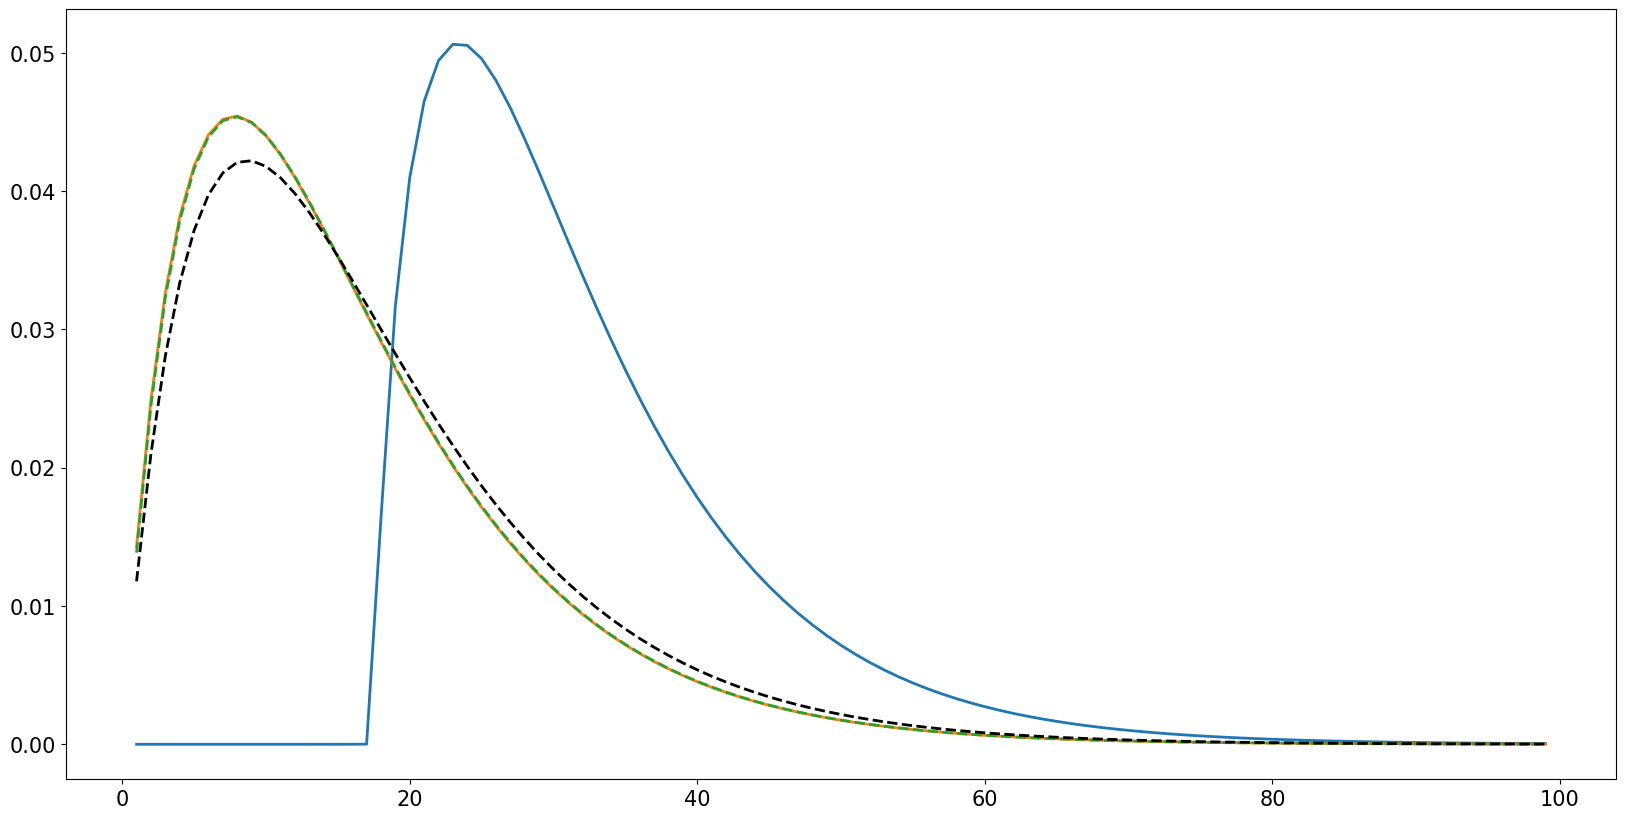

In [ ]:

plt.plot(ds,emergence_d_t_small.sum(axis=1)*ts_small[1]/np.sum(emergence_d_t_small.sum(axis=1)*ts_small[1]))
plt.plot(ds,emergence_d_t_big.sum(axis=1)*ts_big[1]/np.sum(emergence_d_t_big.sum(axis=1)*ts_big[1]))
# plt.plot(ds,emergence_d_t_adiab_small.sum(axis=1)*ts_small[1]/np.sum(emergence_d_t_adiab_small.sum(axis=1)*ts_small[1]))
plt.plot(ds,emergence_d_t_adiab_big.sum(axis=1)*ts_big[1]/np.sum(emergence_d_t_adiab_big.sum(axis=1)*ts_big[1]),ls='--')
rhoc = rhos.flatten()*(1-np.exp(-ds/xi))
plt.plot(ds,rhoc/np.sum(rhoc),color='black',ls='--')
# plt.yscale('log')

/var/folders/r0/2r01pw2j68bcxs_rw3gqyh880000gn/T/ipykernel_1487/445161390.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  emergence_df_small_grouped = emergence_df_small.groupby(['t','d_bin','kappa']).sum().reset_index()
/var/folders/r0/2r01pw2j68bcxs_rw3gqyh880000gn/T/ipykernel_1487/445161390.py:78: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  emergence_df_big_grouped = emergence_df_big.groupby(['t','d_bin','kappa']).sum().reset_index()


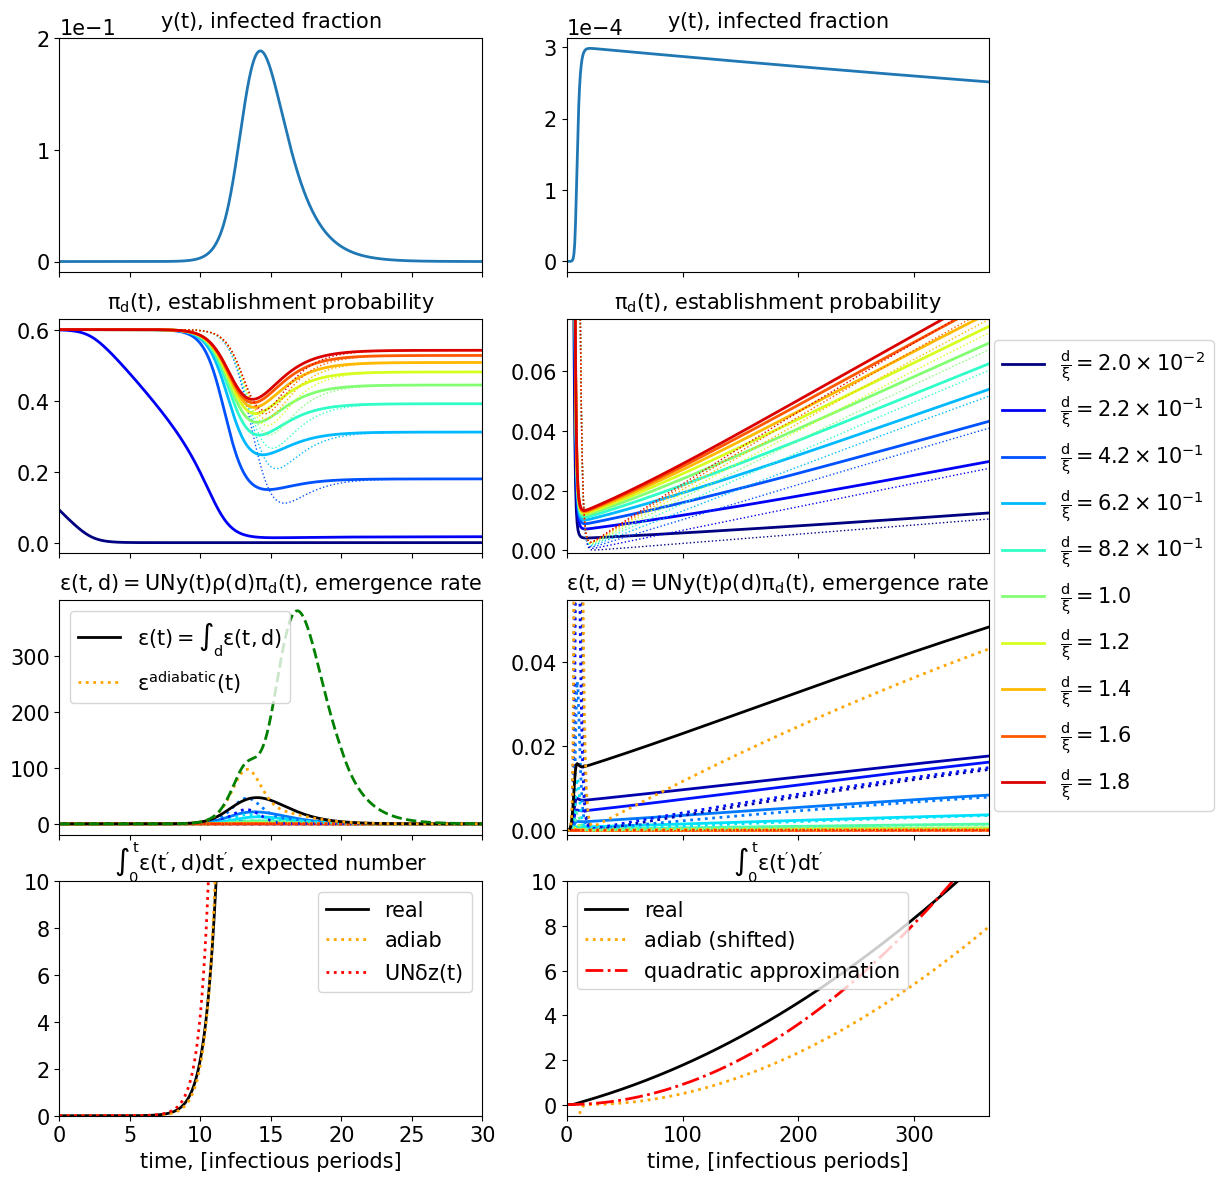

In [ ]:
R0 = 2.5
N=1e10
dbar = 10
xi = 50
delta= dbar/xi
deltacorr = delta/(1+delta)
U = 1e-6
ds = np.arange(1,10*dbar)
rhos = rho_d(ds,dbar).reshape(-1,1)
plot_adiabatic = True

colors_d= funcs.color_dict(ds,plt.cm.jet)

fit_func = lambda x,y,z, c, R0, kappa: R0/(1+kappa*y) * (x + (1-c)*z) -1 
savefig = 1

compute_kappa_small = 1
if compute_kappa_small:
    kappa_small = 1
    ts_small, sol_small = integrate_trajectory(R0,kappa_small,N)
    S_small, I_small = sol_small
    xs_small, ys_small = S_small/N, I_small/N
    zs_small = 1-xs_small-ys_small
    zinf_small = 1-funcs.x_inf(R0,kappa_small)
    dmin_small = xi*np.log(R0/(R0-1)*zinf_small)
    tp_small = ts_small[np.argmax(ys_small)]

    fit_d_t_small = np.array( [fit_func(xs_small,ys_small,zs_small,c_d(d,xi), R0, kappa_small) for d in ds])
    p_surv_d_t_small = np.array([get_p_surv_inv_int(fit_d, ts_small[1]-ts_small[0]) for fit_d in fit_d_t_small])
    p_surv_d_t_adiab_small = np.maximum(fit_d_t_small/(1+fit_d_t_small),0)

    emergence_d_t_small = U*N* ys_small*p_surv_d_t_small *rhos
    emergence_d_t_adiab_small = U*N* ys_small*p_surv_d_t_adiab_small *rhos  *(ds>dmin_small).reshape(-1,1)
    emergence_t_small = np.sum(emergence_d_t_small,axis=0)
    emergence_t_adiab_small = np.sum(emergence_d_t_adiab_small,axis=0)
    cumemergence_t_small = np.cumsum(emergence_t_small,axis=0)*ts_small[1]
    cumemergence_t_adiab_small = np.cumsum(emergence_t_adiab_small)*ts_small[1]

    tt_small,dd = np.meshgrid(ts_small,ds)
    emergence_df_small = pd.DataFrame({'t':tt_small.flatten(),'d':dd.flatten(),'emergence':emergence_d_t_small.flatten(),'emergence_adiab':emergence_d_t_adiab_small.flatten()})
    emergence_df_small['kappa'] = small_kappa
    #group by d in with bin size 10 and sum

    ######### emergence_dataframe
    emergence_df_small['d_bin'] = pd.cut(emergence_df_small['d'], bins=np.arange(0,ds.max()+1,10))
    emergence_df_small_grouped = emergence_df_small.groupby(['t','d_bin','kappa']).sum().reset_index()
    emergence_df_small_grouped['d_mid']= emergence_df_small_grouped['d_bin'].apply(lambda x: x.mid)

compute_kappa_big = 1
if compute_kappa_big:
    kappa_big= 5e3
    ts_big, sol_big = integrate_trajectory(R0,kappa_big,N)
    S_big, I_big = sol_big
    xs_big, ys_big = S_big/N, I_big/N
    zs_big = 1-xs_big-ys_big
    zinf_big = 1-funcs.x_inf(R0,kappa_big)
    dmin_big = xi*np.log(R0/(R0-1)*zinf_big)

    fit_d_t_big = np.array( [fit_func(xs_big,ys_big,zs_big,c_d(d,xi), R0, kappa_big) for d in ds])
    p_surv_d_t_big = np.array([get_p_surv_inv_int(fit_d, ts_big[1]-ts_big[0]) for fit_d in fit_d_t_big])
    p_surv_d_t_adiab_big = np.maximum(fit_d_t_big/(1+fit_d_t_big),0)

    emergence_d_t_big = U*N* ys_big*p_surv_d_t_big *rhos
    emergence_d_t_adiab_big = U*N* ys_big*p_surv_d_t_adiab_big *rhos *(ds>dmin_big).reshape(-1,1)
    emergence_t_big = np.sum(emergence_d_t_big,axis=0)
    emergence_t_adiab_big = np.sum(emergence_d_t_adiab_big,axis=0)
    cumemergence_t_big = np.cumsum(emergence_t_big,axis=0)*ts_big[1]
    cumemergence_adiab_t_big = np.cumsum(emergence_t_adiab_big)*ts_big[1]
    cumemergence_t_analytical_big = U*N* delta*((R0-1)/kappa_big)**2 *ts_big**2/2

    tt_big,dd = np.meshgrid(ts_big,ds)
    emergence_df_big = pd.DataFrame({'t':tt_big.flatten(),'d':dd.flatten(),'emergence':emergence_d_t_big.flatten(),'emergence_adiab':emergence_d_t_adiab_big.flatten()})
    emergence_df_big['kappa'] = big_kappa
    #group by d in with bin size 10 and sum

    ######### emergence_dataframe
    emergence_df_big['d_bin'] = pd.cut(emergence_df_big['d'], bins=np.arange(0,ds.max()+1,10))
    emergence_df_big_grouped = emergence_df_big.groupby(['t','d_bin','kappa']).sum().reset_index()
    emergence_df_big_grouped['d_mid']= emergence_df_big_grouped['d_bin'].apply(lambda x: x.mid)

fig,ax= plt.subplots(4,2,figsize=(12,14),sharex='col')
ax = ax.flatten()

plot_kappa_small = True
if plot_kappa_small:
    ax_y_small = ax[0]
    ax_pi_small = ax[2]
    ax_emergence_small = ax[4]
    ax_cumemergence_small = ax[6]

    # tax2 = ax[2].twinx()

    ax_y_small.plot(ts_small,ys_small)
    for d in ds[::10]:
        # ax_pi_small.plot(ts_small, fit_d_t_small[d-1], alpha=0.5,color = colors_d[d])
        ax_pi_small.plot(ts_small, np.average(p_surv_d_t_small[d-1:d+9],axis=0),label = f'd={d}',color=colors_d[d],lw=2)
        
        # ax_emergence_small.plot(ts_small, emergence_d_t_small[d],label = f'd={d}',color=colors_d[d],lw=1)
        if d>dmin_small and plot_adiabatic:
            ax_pi_small.plot(ts_small, np.average(p_surv_d_t_adiab_small[d-1:d+9],axis=0),label = f'd={d}',color=colors_d[d],ls= ':',lw=1)
            # ax_emergence_small.plot(ts_small, emergence_d_t_adiab_small[d],label = f'd={d}',color=colors_d[d],lw=1,ls=':')
    sns.lineplot(data=emergence_df_small_grouped, x='t',y='emergence',hue='d_mid',legend=False,ax=ax_emergence_small,palette=colors_d)
    sns.lineplot(data=emergence_df_small_grouped, x='t',y='emergence_adiab',hue='d_mid',legend=False,ax=ax_emergence_small,palette=colors_d,ls=':')
    ax_emergence_small.plot(ts_small,emergence_t_small,color='black',ls='-',label=r'$\varepsilon(t)=\int_d \varepsilon(t,d)$')
    ax_emergence_small.plot(ts_small, emergence_t_adiab_small,color='orange',ls=':',label=r'$\varepsilon^{\mathrm{adiabatic}}(t)$')
    ax_cumemergence_small.plot(ts_small,cumemergence_t_small,color='black',ls='-',label='real')
    ax_cumemergence_small.plot(ts_small,cumemergence_t_adiab_small,color='orange',ls=':',label='adiab')
    ax_cumemergence_small.plot(ts_small, U*N*delta*zs_small,color='red',ls=':', label=r'$U N \delta z(t) $')
                            
    junk = False
    if junk:
        print('junk')
        # zinf_small = 1-funcs.x_inf(R0,small_kappa)
        # zp_small = zs_small[np.argmax(ys_small)]
        
        # ax_cumemergence_small.axhline(U*N*deltacorr*((zinf_small)**2/2 - zp_small**2/2),color='red',ls='--')

        # exp_branch_right = 1/2 + 1/2*(1- np.exp(final_g_rate*(ts_small[ts_small>=tp_small]-tp_small)) )
        # exp_branch_left = np.exp((R0-1)*ts_small[ts_small<tp_small])/N
        # final_g_rate = R0*find_x_inf(R0,small_kappa)-1
        # ax_cumemergence_small.plot(ts_small[ts_small<tp_small],np.exp((R0-1)*ts_small[ts_small<tp_small])/N,color='black',ls='--')
        # ax_cumemergence_small.plot(ts_small[ts_small>=tp_small],exp_branch_right,color='orange',ls='--')
        # ax_cumemergence_small.set_yscale('log')
        # tax0 = ax[0].twinx()
        # tax0.plot(ts_small,emergence_t_small,color='red',ls='--')
        # ax_pi_small.set_ylim(-.1,1)
        # ax_emergence_small.set_ylim(-.1,.5)
    
    ax_y_small.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
    ax_y_small.set_yticks(np.arange(3)*1e-1)
    ax_y_small.set_title(r'$y(t)$, infected fraction',fontsize=15,y= 1.01)
    ax_pi_small.set_title(r'$\pi_d(t)$, establishment probability',fontsize=15,y= 1.01)
    ax_pi_small.set_xlim(0,30)
    
    ax_emergence_small.legend(loc='best',fontsize=15)
    ax_emergence_small.set_title(r'$\varepsilon(t,d)= UN y(t)\rho(d)\pi_d(t) $, emergence rate',fontsize=15,y= 1.01)
    test_epsilon_small = U*N*ys_small*(1 - ((1 + ys_small*kappa_small)*(xs_small - zs_small*(delta + np.log((R0*zinf_small)/(-1 + R0)))))/(R0*xs_small**2*((R0*zinf_small)/(-1 + R0))**(1/delta)))
    test_epsilon_small = U*N*ys_small*np.minimum((R0*xs_small**2 - xs_small*(1 + ys_small*kappa_small) + zs_small*delta*(1 + ys_small*kappa_small) + (zs_small + ys_small*zs_small*kappa_small)*np.log((R0*zinf_small)/(-1 + R0)))/(R0*xs_small**2*((R0*zinf_small)/(-1 + R0))**(1/delta)),1)
    ax_emergence_small.plot(ts_small,test_epsilon_small,color='green',ls='--',label='test')

    ax_cumemergence_small.set_title(r'$\int_0^t \varepsilon(t^\prime,d) dt^\prime$, expected number',fontsize=15,y= 1.01)
    ax_cumemergence_small.legend(loc='best',fontsize=15)
    ax_cumemergence_small.set_xlabel('time, [infectious periods]',fontsize=15)
    ax_cumemergence_small.set_ylim(0,10)

plot_kappa_big = True
if plot_kappa_big:      
    ax_y_big = ax[1]
    ax_pi_big = ax[3]
    ax_emergence_big = ax[5]
    ax_cumemergence_big = ax[7]

    ax_y_big.plot(ts_big,ys_big)
    ax_y_big.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

    for d in ds[::10]:
        # ax_pi_big.plot(ts_big, fit_d_t_big[d-1], alpha=0.5,color = colors_d[d])
        ax_pi_big.plot(ts_big, np.average(p_surv_d_t_big[d-1:d+9],axis=0),label = f'd={d}',color=colors_d[d],lw=2)
        
        # ax_emergence_big.plot(ts_big, emergence_d_t_big[d],label = f'd={d}',color=colors_d[d],lw=1)
        if d>dmin_big and plot_adiabatic:
            ax_pi_big.plot(ts_big,  np.average(p_surv_d_t_adiab_big[d-1:d+9],axis=0),label = f'd={d}',color=colors_d[d],ls= ':',lw=1)
            # ax_emergence_big.plot(ts_big, emergence_d_t_adiab_big[d],label = f'd={d}',color=colors_d[d],lw=1,ls=':')
    sns.lineplot(data=emergence_df_big_grouped, x='t',y='emergence',hue='d_mid',legend=False,ax=ax_emergence_big,palette=colors_d)
    sns.lineplot(data=emergence_df_big_grouped, x='t',y='emergence_adiab',hue='d_mid',legend=False,ax=ax_emergence_big,palette=colors_d,ls=':')
    ax_emergence_big.plot(ts_big,emergence_t_big,color='black',ls='-',label=r'$\varepsilon(t)=\int_d \varepsilon(t,d)$')
    ax_emergence_big.plot(ts_big, emergence_t_adiab_big,color='orange',ls=':',label=r'$\varepsilon^{\mathrm{adiabatic}}(t)$')
    ax_cumemergence_big.plot(ts_big,cumemergence_t_big,color='black',ls='-',label='real')
    ax_cumemergence_big.plot(ts_big,cumemergence_adiab_t_big - cumemergence_adiab_t_big[np.argmax(ys_big)],color='orange',ls=':',label='adiab (shifted)')
    ax_cumemergence_big.plot(ts_big,cumemergence_t_analytical_big,color='red',ls='-.',label='quadratic approximation')

    ax_pi_big.set_xlim(0,kappa_big/(R0-1)* np.sqrt(20/(U*N*deltacorr)))
    ax_pi_big.set_ylim(-1e-3,np.sqrt(10/(U*N*deltacorr)))

    ax_y_big.set_title(r'$y(t)$, infected fraction',fontsize=15,y= 1.01)
    ax_pi_big.set_title(r'$\pi_d(t)$, establishment probability',fontsize=15,y= 1.01)

    emergence_big_ylim_top = np.sqrt(20* U*N*deltacorr)*(R0-1)/kappa_big

    ax_emergence_big.set_ylim(-1e-3,emergence_big_ylim_top)
    ax_emergence_big.legend(loc='best',fontsize=15)
    ax_emergence_big.set_title(r'$\varepsilon(t,d)= UN y(t)\rho(d)\pi_d(t) $, emergence rate',fontsize=15,y= 1.01)

    ax_cumemergence_big.set_ylim(-.5,10)
    ax_cumemergence_big.set_title(r'$\int_0^t \varepsilon(t^\prime) dt^\prime$',fontsize=15,y= 1.01)
    ax_cumemergence_big.set_xlabel('time, [infectious periods]',fontsize=15)
    ax_cumemergence_big.legend(loc='best',fontsize=15)
    ax_cumemergence_big.set_yticks(ax_cumemergence_small.get_yticks())

for a in ax:
    a.set_ylabel('')

handles_d = [Line2D([0], [0], color=colors_d[d], lw=2, label = r'$\frac{d}{\xi}=$'+ exp_notation_string(d/xi) ) for d in ds[::10]]
ax[5].legend(handles=handles_d,loc=(1.01,.1),fontsize=15)
savefig=0
if savefig:
    plt.savefig(output_folder+f'alt_comparison_kappa_small_{small_kappa:.0e}_big_{big_kappa:.0e}_d_{dbar}_xi_{xi}_R0_{R0}_UN_{U*N:.0e}.svg',bbox_inches='tight')

In [ ]:
dmin_small

17.363760639850685

In [ ]:
sps.gamma()

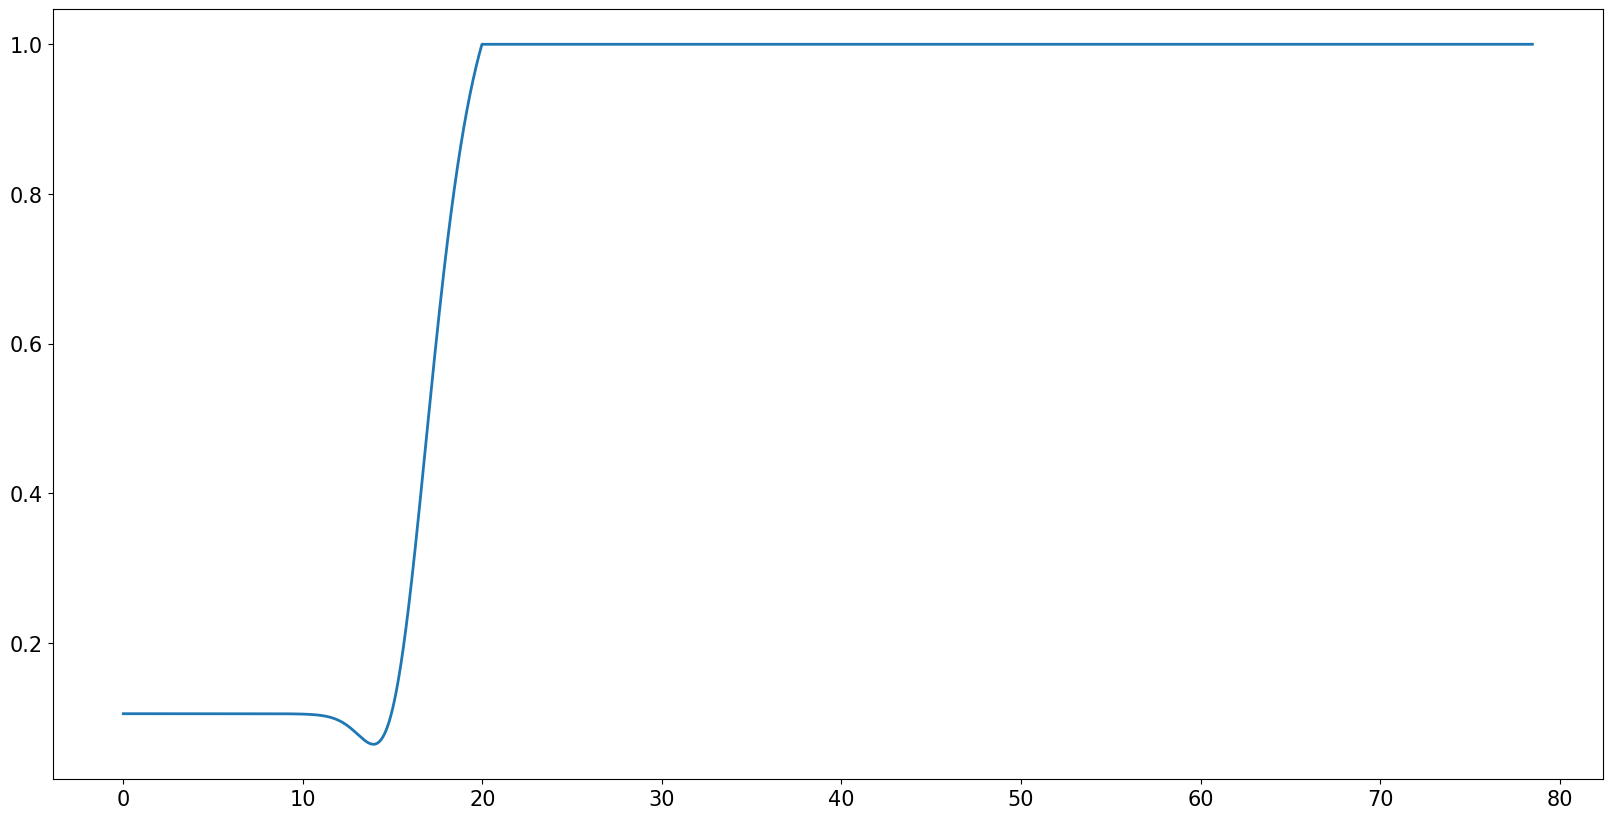

In [ ]:
# plt.plot(ts_small,test_epsilon_small,color='green',ls='--',label='test')

test = 1 - ((1 + ys_small*kappa_small)*(xs_small - zs_small*delta - zs_small*np.log((R0*zinf_small)/(-1 + R0))))/(R0*xs_small**2*((R0*zinf_small)/(-1 + R0))**(1/delta))
test2 =np.minimum((R0*xs_small**2 - xs_small*(1 + ys_small*kappa_small) + zs_small*delta*(1 + ys_small*kappa_small) + (zs_small + ys_small*zs_small*kappa_small)*np.log((R0*zinf_small)/(-1 + R0)))/(R0*xs_small**2*((R0*zinf_small)/(-1 + R0))**(1/delta)),1)

plt.plot(ts_small[:],test2[:])

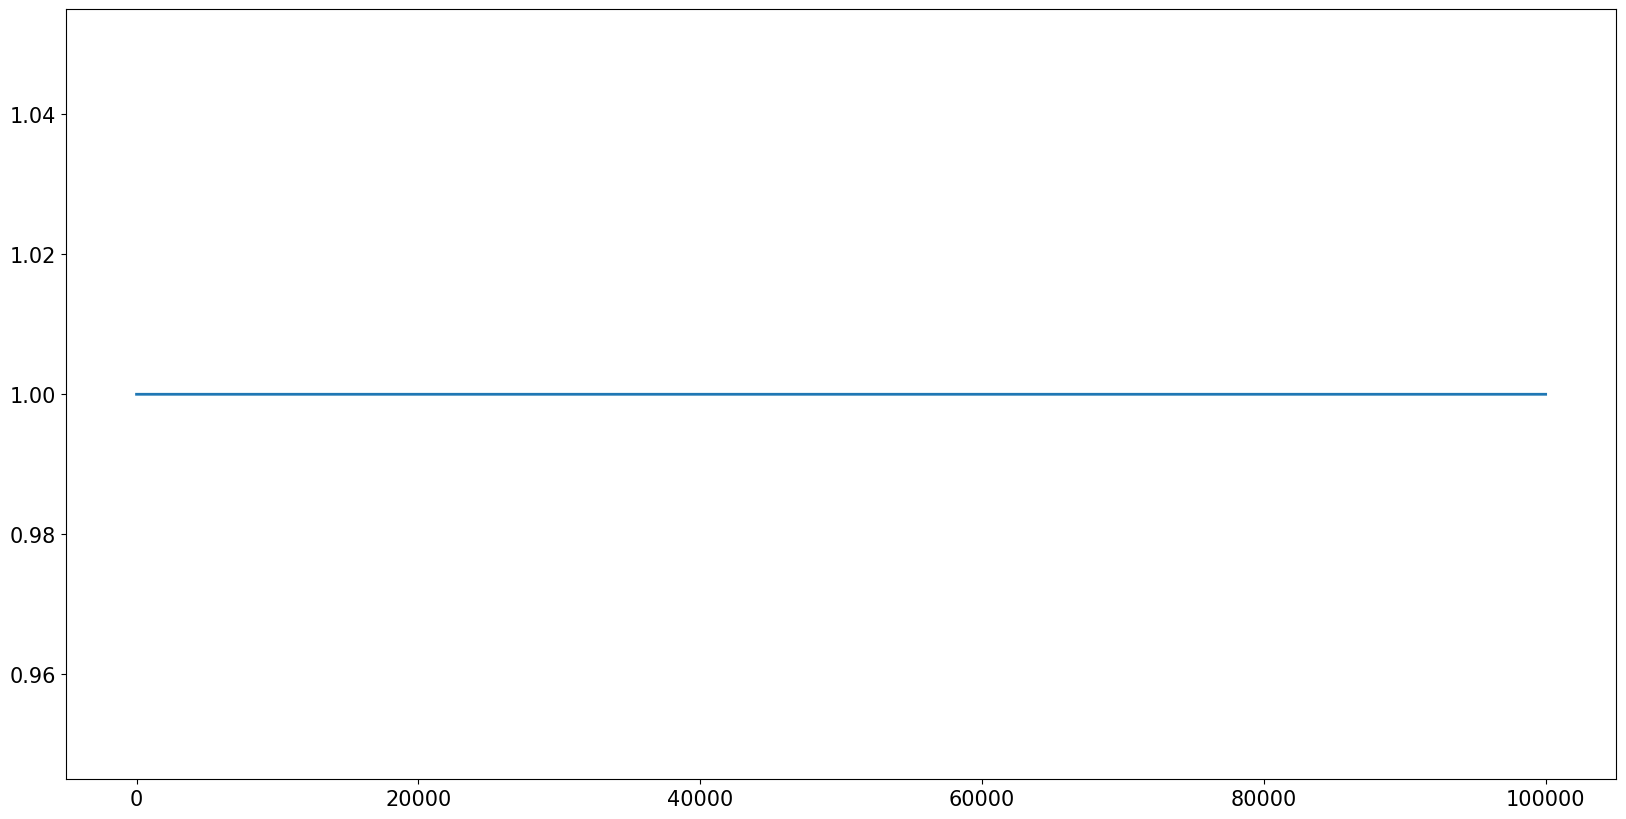

In [ ]:
x,y,z = xs_small[20000],ys_small[20000],zs_small[20000]
plt.plot(sps.gammainc(0,(xs_small + zs_small* np.log((R0 *zinf_small)/(-1 + R0)))/(zs_small * delta)))

In [ ]:
xs_small[20000],ys_small[20000],zs_small[20000],zinf_small

(0.28238299059050365,
 0.13742870474517177,
 0.5801883046643246,
 0.8491236927745072)

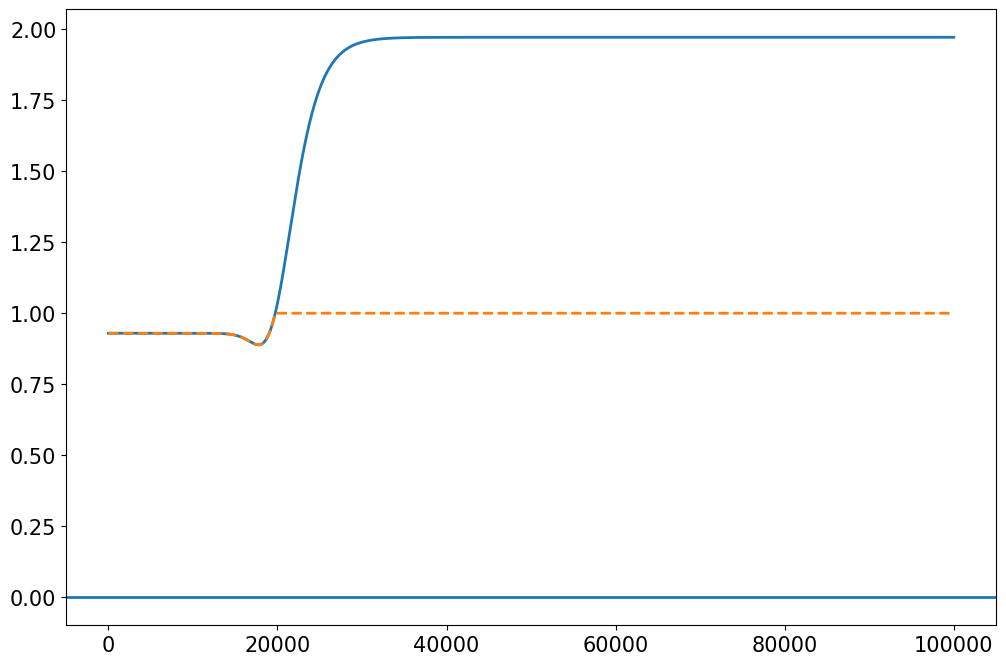

In [ ]:
fig,ax= plt.subplots(1,1,figsize=(12,8))
plt.plot(1 -((1 + ys_small*kappa_small)*(xs_small - zs_small*(delta + np.log((R0*zinf_small)/(-1 + R0)))))/(R0*xs_small**2*((R0*zinf_small)/(-1 + R0))**(1/delta)))
plt.plot(np.minimum(1 - ((1 + ys_small*kappa_small)*(xs_small - zs_small*delta - zs_small*np.log((R0*zinf_small)/(-1 + R0))))/(R0*xs_small**2*((R0*zinf_small)/(-1 + R0))**(1/delta)),1),ls='--')
# ylim = ax.get_ylim()
# plt.plot(1 - (np.e**(1/dbar + xs_small/(zs_small*delta))*(1 + ys_small*kappa_small)*sps.gammainc(0,(xs_small + zs_small*np.log((R0*zinf_small)/(-1 + R0)))/(zs_small*delta)))/(R0*zs_small*delta))
# ax.set_ylim(ylim)
plt.axhline(0)

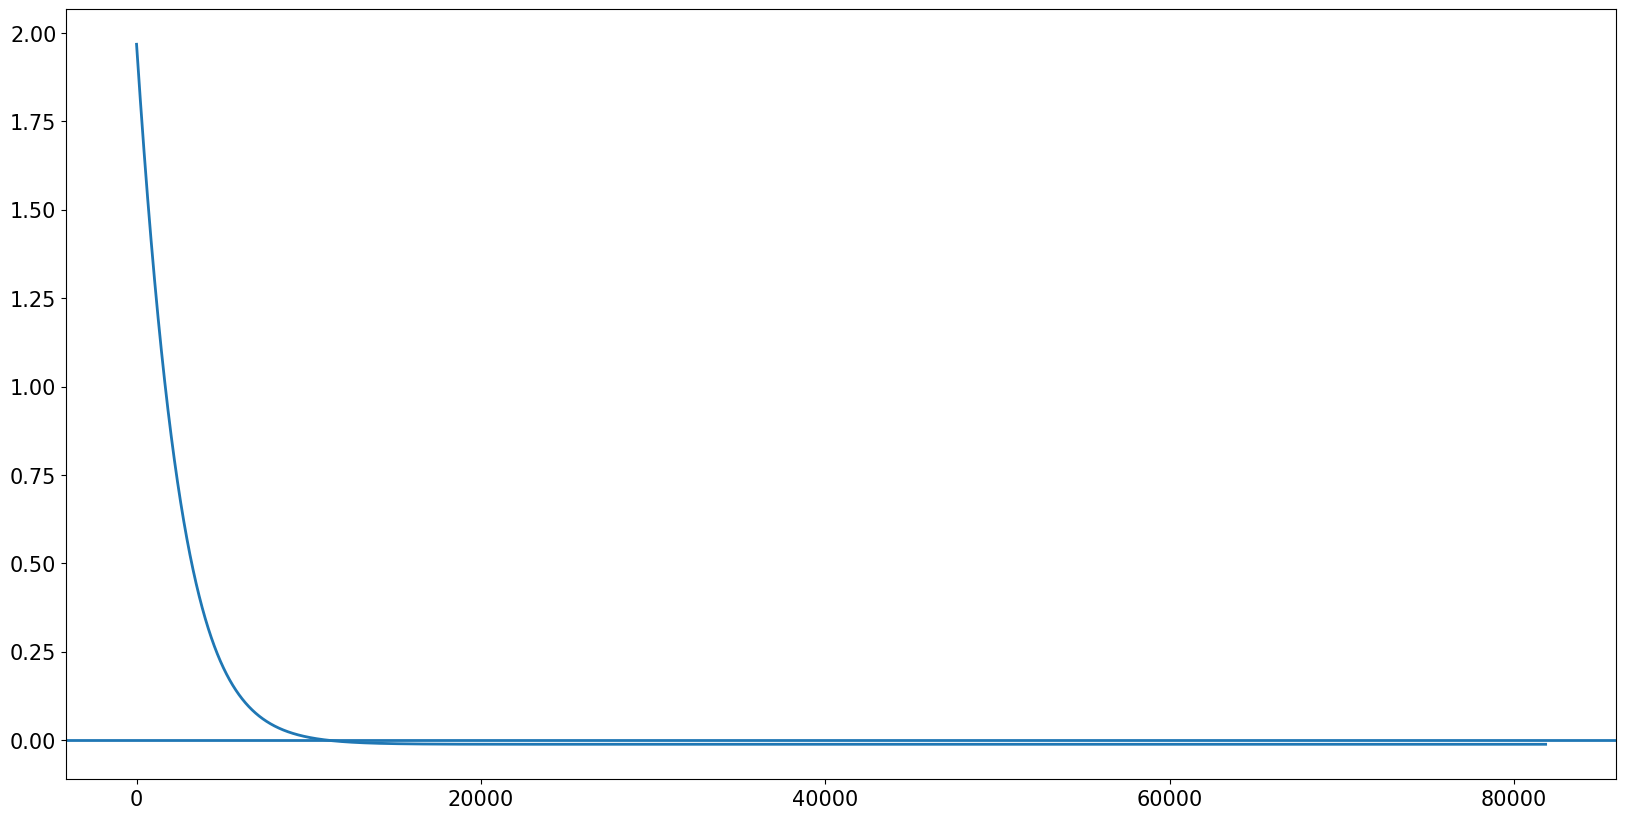

In [ ]:
plt.plot(np.log(1/dbar+ xs_small[ts_small>tp_small]/(zs_small[ts_small>tp_small]*delta)))
# plt.yscale('log')
plt.axhline(0)

Text(0.5, 0, 'time, [infectious periods]')

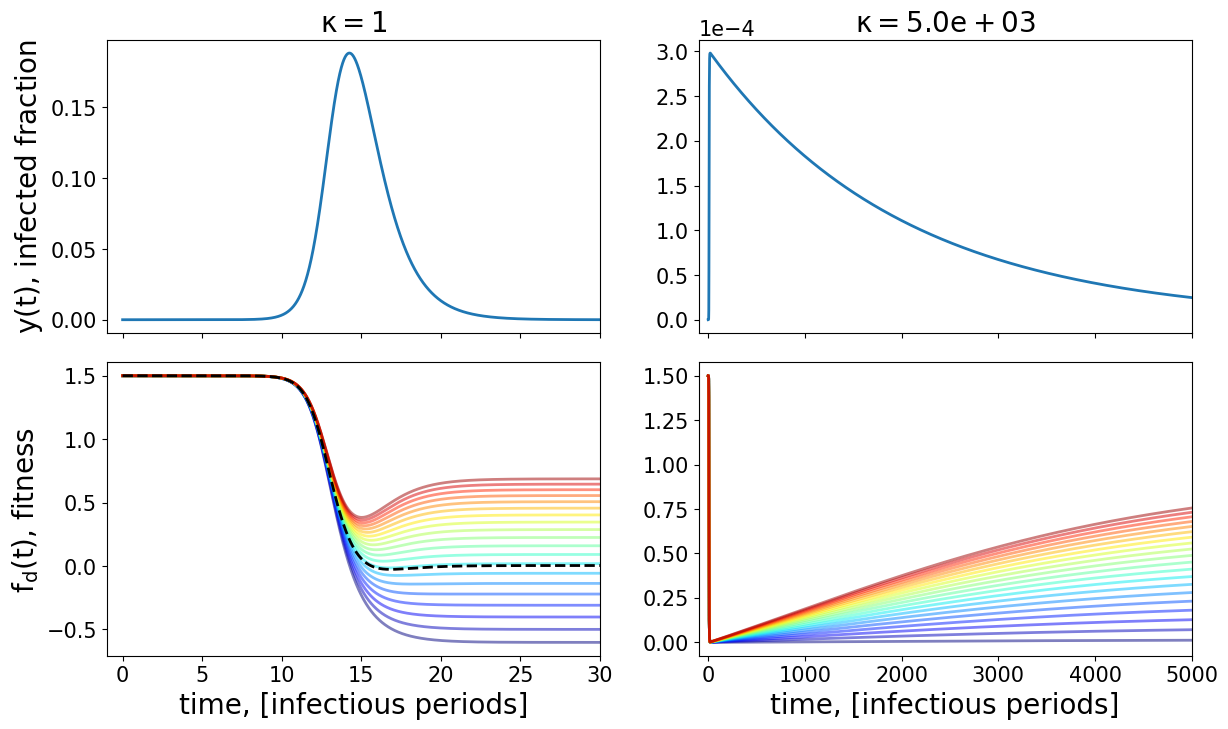

In [ ]:
R0 = 2.5
N=1e10
dbar = 10
xi = 50
delta= dbar/xi
deltacorr = delta/(1+delta)
U = 1e-6
ds = np.arange(1,10*dbar)
rhos = rho_d(ds,dbar).reshape(-1,1)
plot_adiabatic = True

colors_d= funcs.color_dict(ds,plt.cm.jet)

fit_func = lambda x,y,z, c, R0, kappa: R0/(1+kappa*y) * (x + (1-c)*z) -1 
savefig = 1

dbinsize= 5

compute_kappa_small = 0
if compute_kappa_small:
    kappa_small = 1
    ts_small, sol_small = integrate_trajectory(R0,kappa_small,N)
    S_small, I_small = sol_small
    xs_small, ys_small = S_small/N, I_small/N
    zs_small = 1-xs_small-ys_small
    zinf_small = 1-funcs.x_inf(R0,kappa_small)
    dmin_small = xi*np.log(R0/(R0-1)*zinf_small)
    tp_small = ts_small[np.argmax(ys_small)]

    fit_d_t_small = np.array( [fit_func(xs_small,ys_small,zs_small,c_d(d,xi), R0, kappa_small) for d in ds])
    # p_surv_d_t_small = np.array([get_p_surv_inv_int(fit_d, ts_small[1]-ts_small[0]) for fit_d in fit_d_t_small])
    # p_surv_d_t_adiab_small = np.maximum(fit_d_t_small/(1+fit_d_t_small),0)

    # emergence_d_t_small = U*N* ys_small*p_surv_d_t_small *rhos
    # emergence_d_t_adiab_small = U*N* ys_small*p_surv_d_t_adiab_small *rhos  *(ds>dmin_small).reshape(-1,1)
    # emergence_t_small = np.sum(emergence_d_t_small,axis=0)
    # emergence_t_adiab_small = np.sum(emergence_d_t_adiab_small,axis=0)
    # cumemergence_t_small = np.cumsum(emergence_t_small,axis=0)*ts_small[1]
    # cumemergence_t_adiab_small = np.cumsum(emergence_t_adiab_small)*ts_small[1]

    # tt_small,dd = np.meshgrid(ts_small,ds)
    # emergence_df_small = pd.DataFrame({'t':tt_small.flatten(),'d':dd.flatten(),'emergence':emergence_d_t_small.flatten(),'emergence_adiab':emergence_d_t_adiab_small.flatten()})
    # emergence_df_small['kappa'] = kappa_small
    # #group by d in with bin size 10 and sum

    # ######### emergence_dataframe
    # emergence_df_small['d_bin'] = pd.cut(emergence_df_small['d'], bins=np.arange(0,ds.max()+1,10))
    # emergence_df_small_grouped = emergence_df_small.groupby(['t','d_bin','kappa']).sum().reset_index()
    # emergence_df_small_grouped['d_mid']= emergence_df_small_grouped['d_bin'].apply(lambda x: x.mid)

compute_kappa_big = 0
if compute_kappa_big:
    kappa_big= 5e3
    ts_big, sol_big = integrate_trajectory(R0,kappa_big,N)
    S_big, I_big = sol_big
    xs_big, ys_big = S_big/N, I_big/N
    zs_big = 1-xs_big-ys_big
    zinf_big = 1-funcs.x_inf(R0,kappa_big)
    dmin_big = xi*np.log(R0/(R0-1)*zinf_big)

    fit_d_t_big = np.array( [fit_func(xs_big,ys_big,zs_big,c_d(d,xi), R0, kappa_big) for d in ds])
    # p_surv_d_t_big = np.array([get_p_surv_inv_int(fit_d, ts_big[1]-ts_big[0]) for fit_d in fit_d_t_big])
    # p_surv_d_t_adiab_big = np.maximum(fit_d_t_big/(1+fit_d_t_big),0)

    # emergence_d_t_big = U*N* ys_big*p_surv_d_t_big *rhos
    # emergence_d_t_adiab_big = U*N* ys_big*p_surv_d_t_adiab_big *rhos *(ds>dmin_big).reshape(-1,1)
    # emergence_t_big = np.sum(emergence_d_t_big,axis=0)
    # emergence_t_adiab_big = np.sum(emergence_d_t_adiab_big,axis=0)
    # cumemergence_t_big = np.cumsum(emergence_t_big,axis=0)*ts_big[1]
    # cumemergence_adiab_t_big = np.cumsum(emergence_t_adiab_big)*ts_big[1]
    # cumemergence_t_analytical_big = U*N* delta*((R0-1)/kappa_big)**2 *ts_big**2/2

    # tt_big,dd = np.meshgrid(ts_big,ds)
    # emergence_df_big = pd.DataFrame({'t':tt_big.flatten(),'d':dd.flatten(),'emergence':emergence_d_t_big.flatten(),'emergence_adiab':emergence_d_t_adiab_big.flatten()})
    # emergence_df_big['kappa'] = kappa_big
    # #group by d in with bin size 10 and sum

    # ######### emergence_dataframe
    # emergence_df_big['d_bin'] = pd.cut(emergence_df_big['d'], bins=np.arange(0,ds.max()+1,10))
    # emergence_df_big_grouped = emergence_df_big.groupby(['t','d_bin','kappa']).sum().reset_index()
    # emergence_df_big_grouped['d_mid']= emergence_df_big_grouped['d_bin'].apply(lambda x: x.mid)

fig,ax= plt.subplots(2,2,figsize=(14,8),sharex='col')
plt.subplots_adjust(hspace=0.1)
ax= ax.flatten()
plot_kappa_small = True

if plot_kappa_small:
    ax_y_small = ax[0]
    ax_fit_small = ax[2]

    ax_y_small.plot(ts_small,ys_small)

    for d in ds[::dbinsize]:
        ax_fit_small.plot(ts_small, fit_d_t_small[d-1], alpha=0.5,color = colors_d[d])
    ax_y_small.set_xlim(-1,30)

ax_fit_small.plot(ts_small,fit_d_t_small[np.round(dmin_small).astype(int)-1],color='black',ls='--',label = r'$d_{\min}$')

ax_y_small.set_title(fr'$\kappa={kappa_small}$')

plot_kappa_big = True
if plot_kappa_big:      
    ax_y_big = ax[1]
    ax_fit_big = ax[3]

    ax_y_big.plot(ts_big,ys_big)

    for d in ds[::dbinsize]:
        ax_fit_big.plot(ts_big, fit_d_t_big[d-1], alpha=0.5,color = colors_d[d])
    ax_y_big.set_xlim(-100,5000)

ax_y_big.set_title(fr'$\kappa={kappa_big:.1e}$')
ax_y_big.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
ax_y_small.set_ylabel(r'$y(t)$'+', infected fraction')
ax_y_big.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
ax_fit_small.set_ylabel(r'$f_d(t)$'+', fitness')

ax_fit_big.set_xlabel('time, [infectious periods]')
ax_fit_small.set_xlabel('time, [infectious periods]')

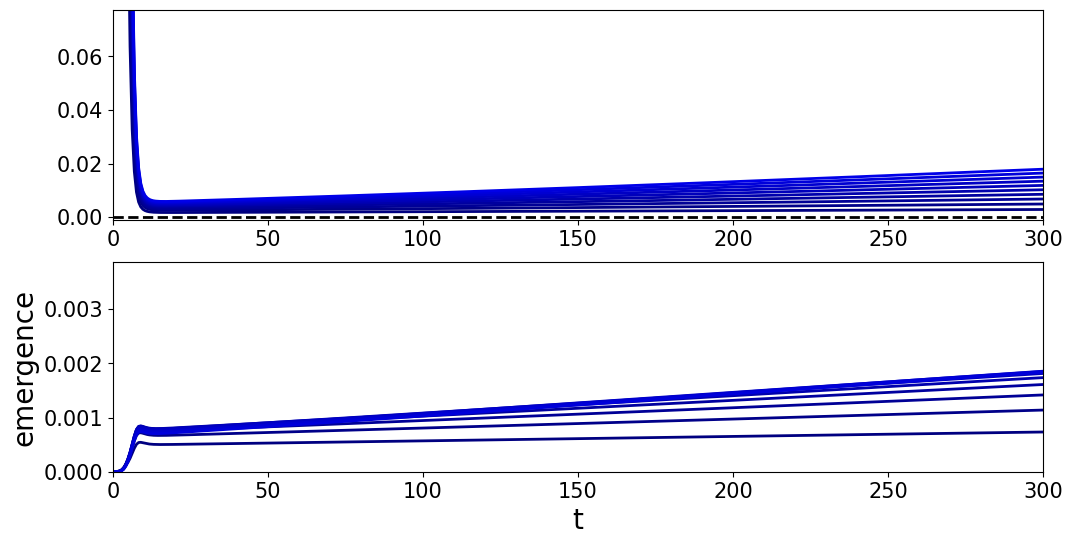

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(12,6))
emergence_big_ylim_top = np.sqrt(10* U*N*deltacorr)*(R0-1)/kappa_big
for d in ds[:10]:
    ax[0].plot(ts_big, p_surv_d_t_big[d-1],label = f'd={d}',color=colors_d[d])

sns.lineplot(data=emergence_df_big.query('d<10'), x='t',y='emergence',hue='d',legend=False,ax=ax[1],palette=colors_d)

ax[0].set_ylim(-1e-3,np.sqrt(10/(U*N*deltacorr)))
ax[0].axhline(0,color='black',ls='--')
ax[1].set_ylim(0,emergence_big_ylim_top/10)
for a in ax:
    a.set_xlim(0,300)


In [ ]:
ds[::10]

array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91])

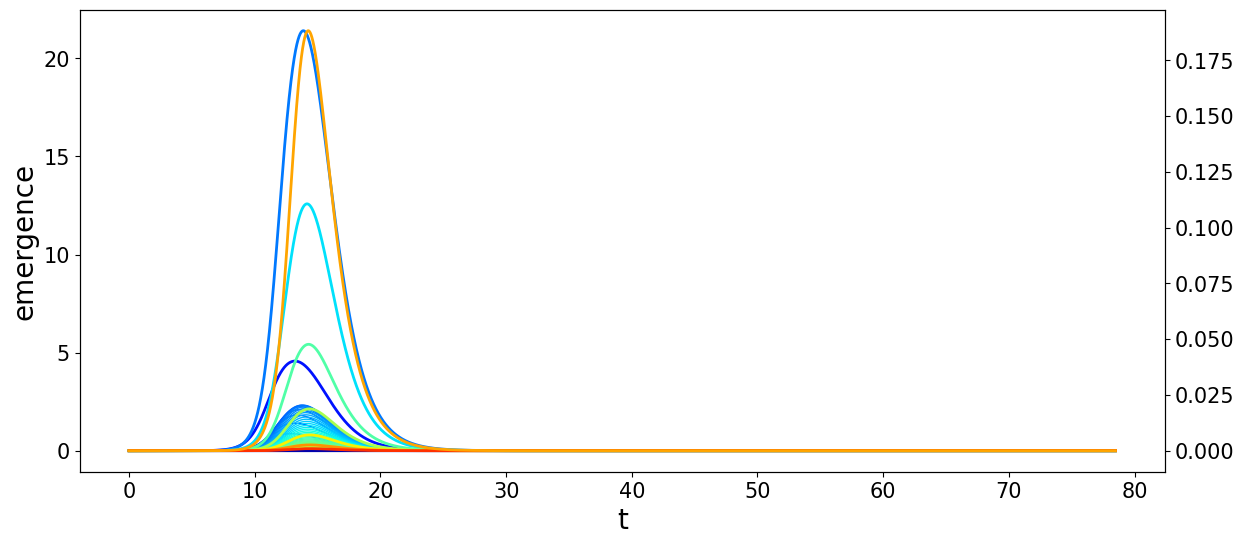

In [ ]:
fig,ax= plt.subplots(figsize=(14,6),sharex='col')

for d in ds:
    ax.plot(ts_small, emergence_d_t_small[d-1],label = f'd={d}',color=colors_d[d],lw=1)
sns.lineplot(data=emergence_df_small_grouped, x='t',y='emergence',hue='d_mid',legend=False,ax=ax,palette=colors_d)
tax = ax.twinx()
tax.plot(ts_small,ys_small,color='orange')

In [ ]:


emergence_df_big_grouped

,t,d_bin,kappa,d,emergence,emergence_adiab,d_mid
0,0.000000,"(0, 10]",1000.0,55,3.907917e-06,3.907916e-06,5.0
1,0.000000,"(10, 20]",1000.0,155,1.362606e-06,1.362606e-06,15.0
2,0.000000,"(20, 30]",1000.0,255,4.751115e-07,4.751114e-07,25.0
3,0.000000,"(30, 40]",1000.0,355,1.656611e-07,1.656611e-07,35.0
4,0.000000,"(40, 50]",1000.0,455,5.776247e-08,5.776245e-08,45.0
...,...,...,...,...,...,...,...
899995,69100.578641,"(40, 50]",1000.0,455,1.291410e-17,1.291410e-17,45.0
899996,69100.578641,"(50, 60]",1000.0,555,4.788103e-18,4.788103e-18,55.0
899997,69100.578641,"(60, 70]",1000.0,655,1.742971e-18,1.742971e-18,65.0
899998,69100.578641,"(70, 80]",1000.0,755,6.270882e-19,6.270882e-19,75.0


In [ ]:
x_big

NameError: name 'x_big' is not defined

In [ ]:
R0_est = 3

In [ ]:
Uns = np.array([1e3,1e4])
delta= 1/5

Uns*delta

kappa_star = (R0_est/(R0_est-1))**2 /delta

global_prev = 1e-3
kappa_prev = (R0_est-1)/global_prev

print(kappa_prev/kappa_star)
print(Uns*delta)

177.77777777777777
[ 200. 2000.]
